In [1]:
import uproot
import awkward as ak
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.numpoints": 1,
    "axes.linewidth": 2,
    "legend.title_fontsize": 18,
    "axes.labelsize": 18,
    "legend.fontsize": 16
})

In [3]:
file = uproot.open("root_files/ntuple_merged_10.root")

In [4]:
file

<ReadOnlyDirectory '/' at 0x0001059a7c10>

In [5]:
file.keys()

['deepntuplizer;1', 'deepntuplizer/tree;42', 'deepntuplizer/tree;41']

In [6]:
df = file['deepntuplizer/tree;42']

In [7]:
df.keys()

['Delta_gen_pt',
 'event_no',
 'gen_pt',
 'isB',
 'isBB',
 'isC',
 'isG',
 'isLeptonicB',
 'isLeptonicB_C',
 'isS',
 'isUD',
 'isUndefined',
 'jet_corr_pt',
 'jet_eta',
 'jet_looseId',
 'jet_no',
 'jet_phi',
 'jet_pt',
 'jet_tightId',
 'npv',
 'ntrueInt',
 'pfBoostedDoubleSecondaryVertexAK8BJetTags',
 'pfCombinedInclusiveSecondaryVertexV2BJetTags',
 'pfCombinedMVAV2BJetTags',
 'pfDeepCSVJetTags_probb',
 'pfDeepCSVJetTags_probbb',
 'pfDeepCSVJetTags_probc',
 'pfDeepCSVJetTags_probcc',
 'pfDeepCSVJetTags_probudsg',
 'pfJetBProbabilityBJetTags',
 'pfJetProbabilityBJetTags',
 'rho',
 'softPFElectronBJetTags',
 'softPFMuonBJetTags',
 'fj_doubleb',
 'fj_eta',
 'fj_gen_eta',
 'fj_gen_pt',
 'fj_isBB',
 'fj_isH',
 'fj_isNonBB',
 'fj_isQCD',
 'fj_isTop',
 'fj_isW',
 'fj_isZ',
 'fj_jetNTracks',
 'fj_label',
 'fj_labelJMAR',
 'fj_labelLegacy',
 'fj_mass',
 'fj_nSV',
 'fj_n_sdsubjets',
 'fj_nbHadrons',
 'fj_ncHadrons',
 'fj_phi',
 'fj_pt',
 'fj_ptDR',
 'fj_relptdiff',
 'fj_sdmass',
 'fj_sdn2',
 'fj

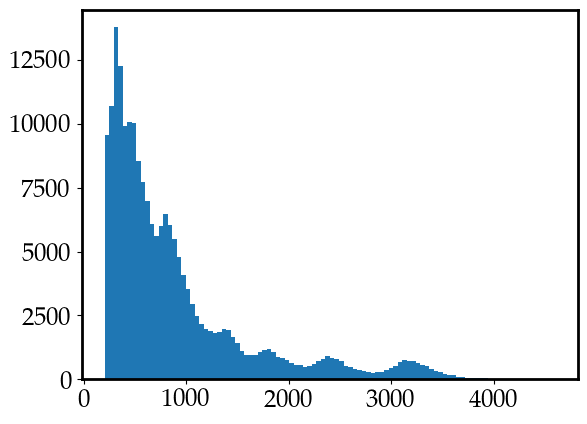

In [9]:
plt.hist(df['fj_pt'].array(), bins = 100)
plt.show()

In [12]:
np.all(df['fj_trackSipdSig_0'].array() > df['fj_trackSipdSig_1'].array())

False

In [9]:
df['fj_trackSipdSig_1'].array()

<Array [2.33, 5.53, 1.71, ... 0.648, 1.14] type='200000 * float32'>

In [15]:
arr = df['fj_pt'].array()

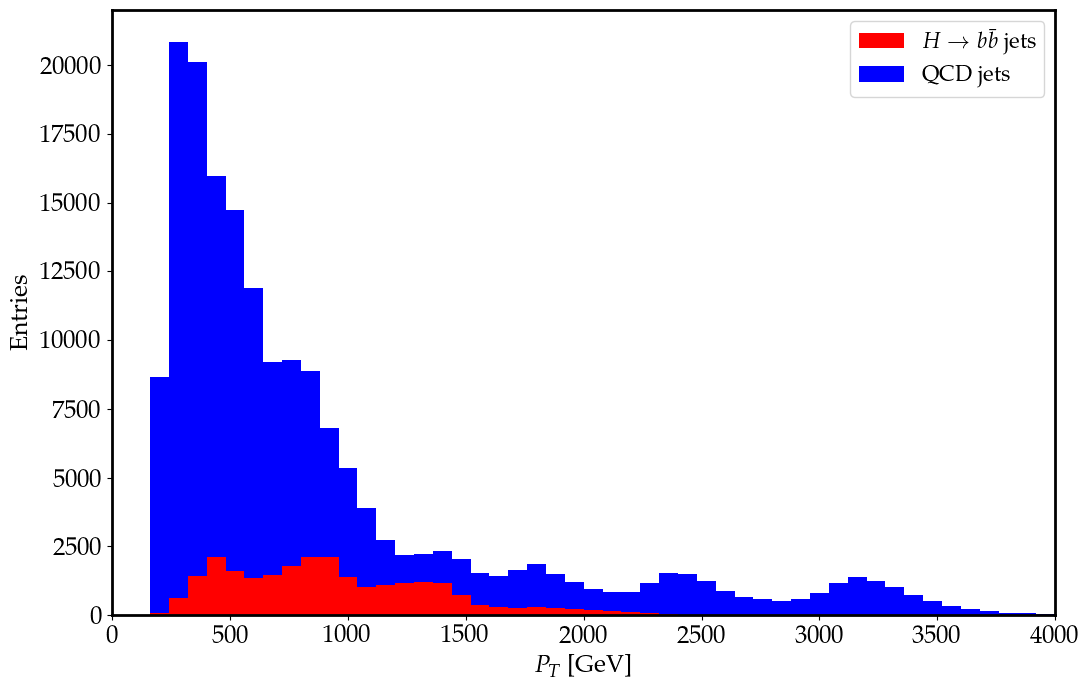

In [16]:
plt.figure(figsize=(11,7))
plt.hist(arr[df['label_H_bb'].array()==1],bins=50,alpha=1,color='r',range=(0,4000),label=r'$H\rightarrow b\bar{b}$ jets',zorder=2)
plt.hist(arr[df['label_H_bb'].array()==0],bins=50,alpha=1,color='b',range=(0,4000),label='QCD jets')
plt.xlabel(r'$P_T$ [GeV]')
plt.ylabel('Entries')
plt.xlim(0,4000)
plt.ylim(0,22000)
plt.legend()
plt.tight_layout()
plt.savefig('hist.pdf')
plt.show()

In [17]:
df['n_tracks'].array()

<Array [21, 35, 24, 32, 28, ... 33, 21, 27, 27] type='200000 * int32'>

In [18]:
df['track_phirel'].array()

<Array [[-0.554, -0.248, ... -0.26, -0.216]] type='200000 * var * float32'>

In [19]:
df['track_pt'].array()[2]

<Array [1.53, 6.82, 2.93, ... 25.7, 36.3, 1.15] type='24 * float32'>

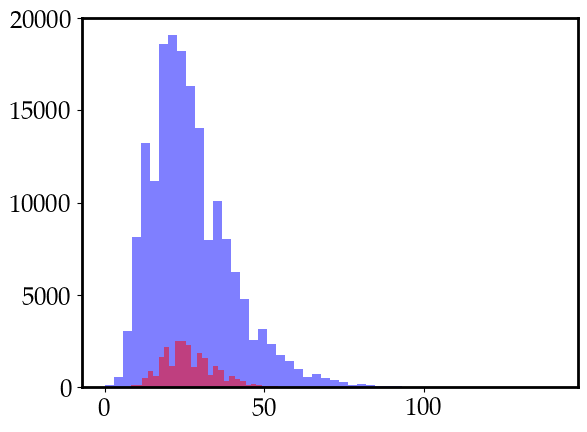

In [24]:
arr = df['ntracks'].array()
plt.hist(arr[df['label_H_bb'].array()==1],alpha=0.5,bins=50,color='r',zorder=2)
plt.hist(arr[df['label_H_bb'].array()==0],alpha=0.5,bins=50,color='b')
plt.show()

  0%|          | 0/219 [00:00<?, ?it/s]

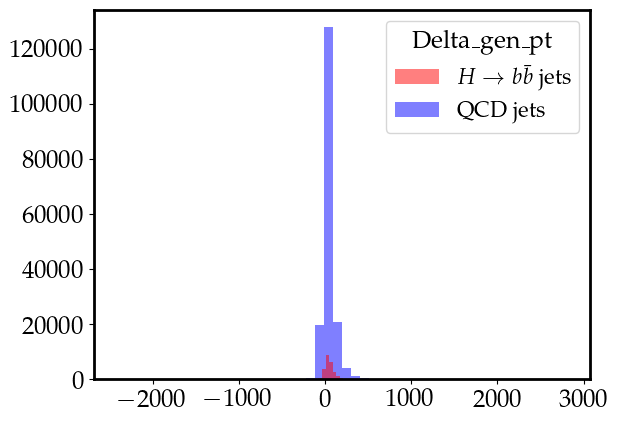

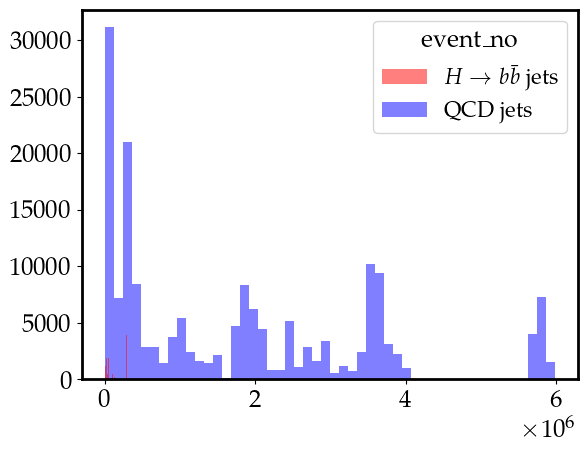

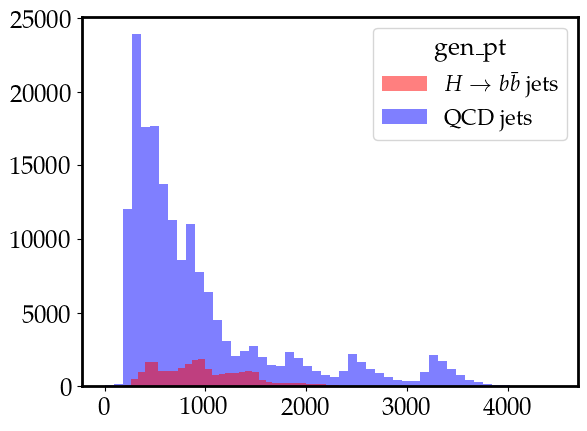

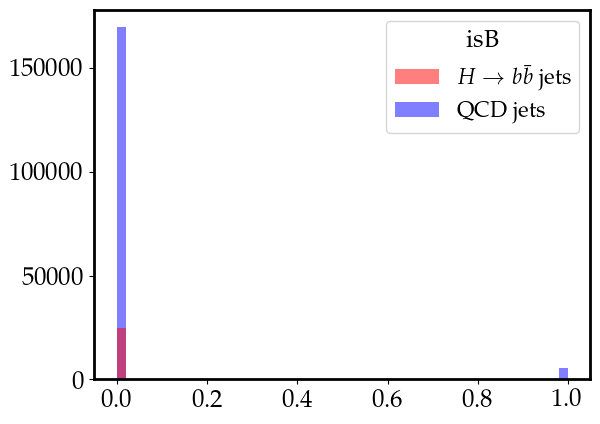

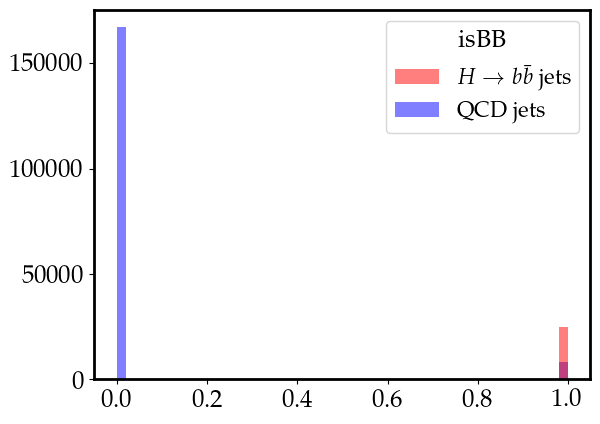

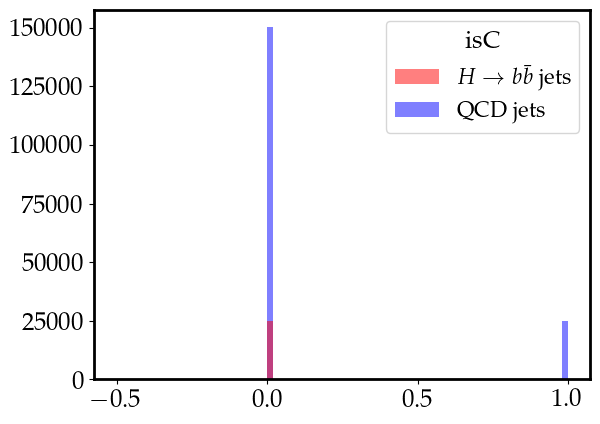

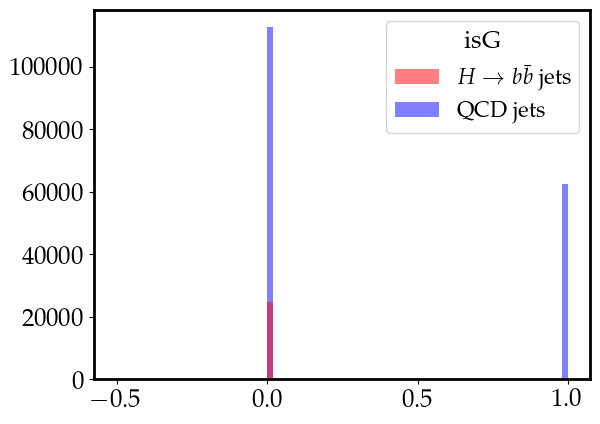

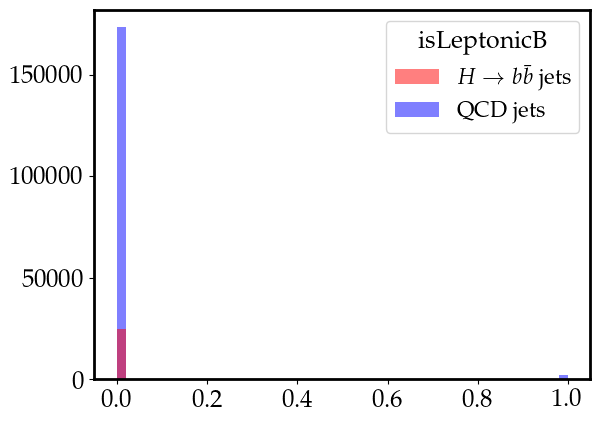

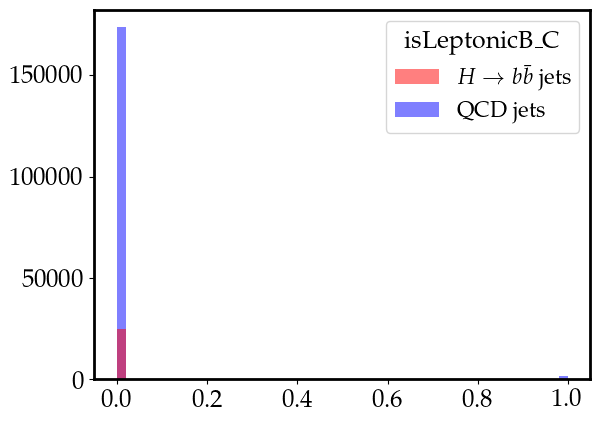

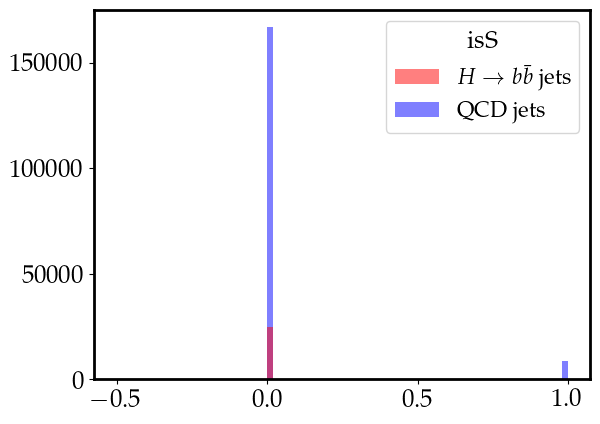

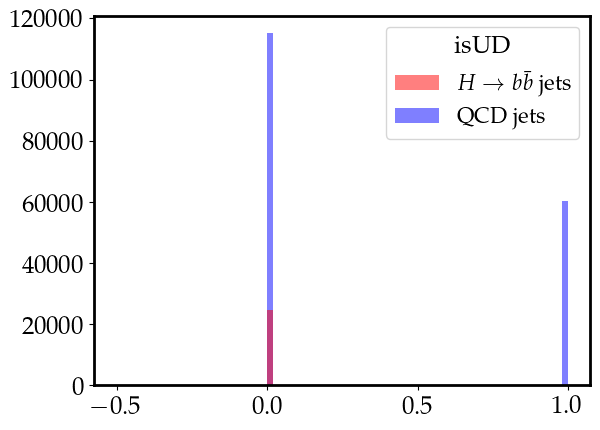

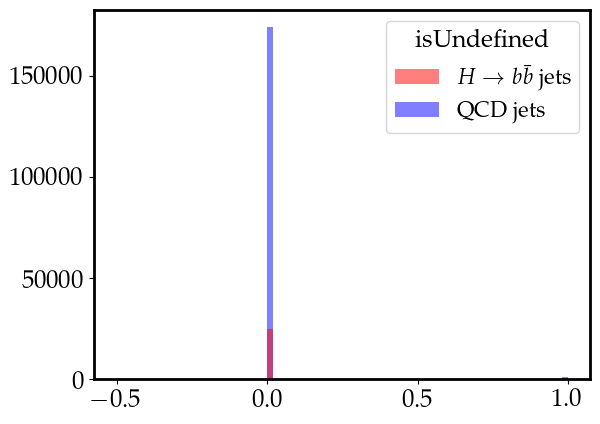

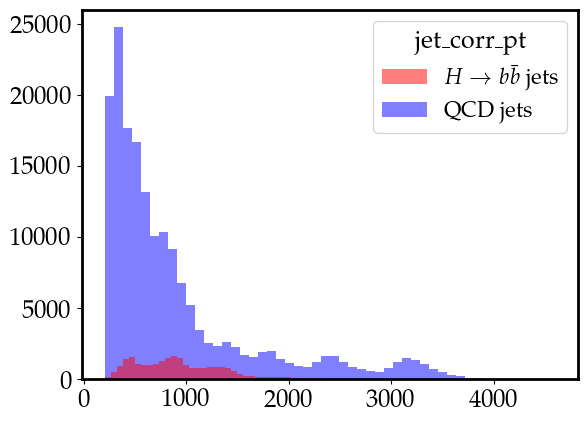

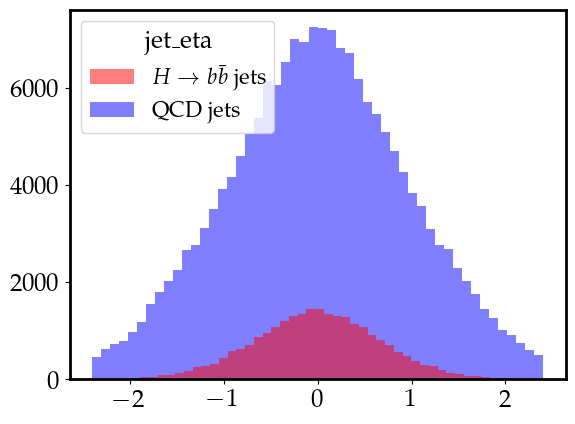

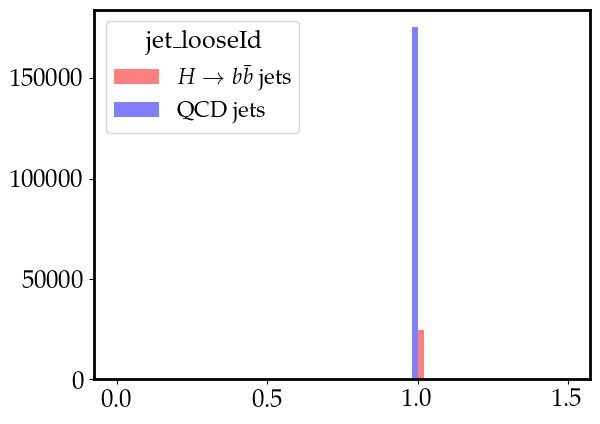

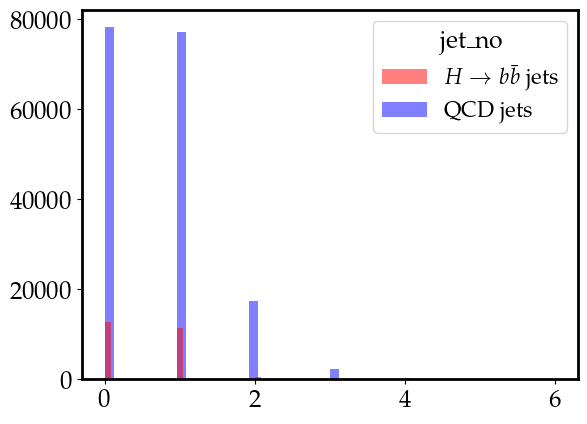

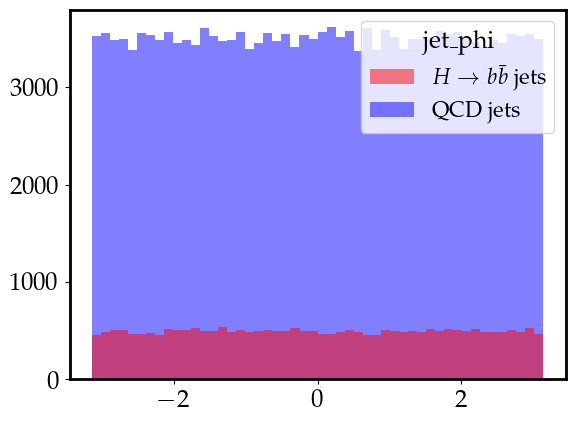

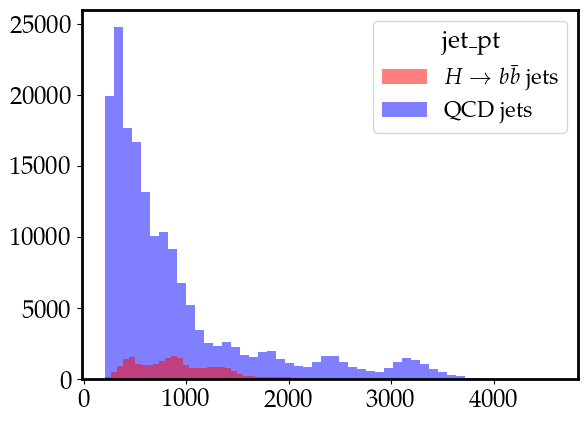

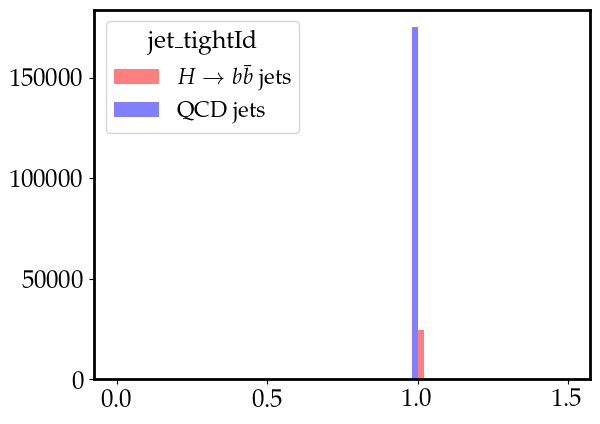

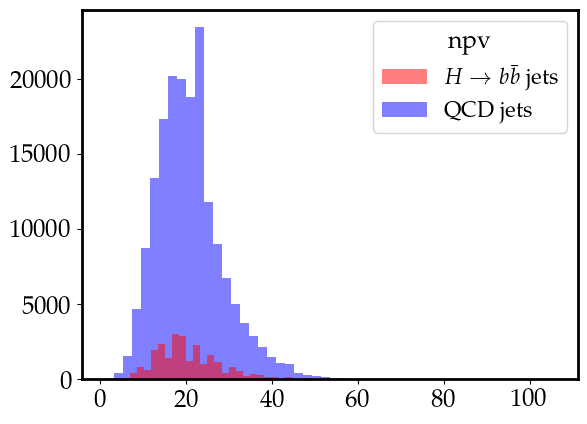

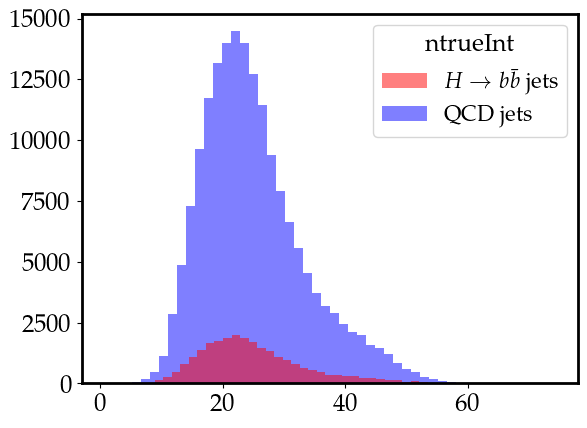

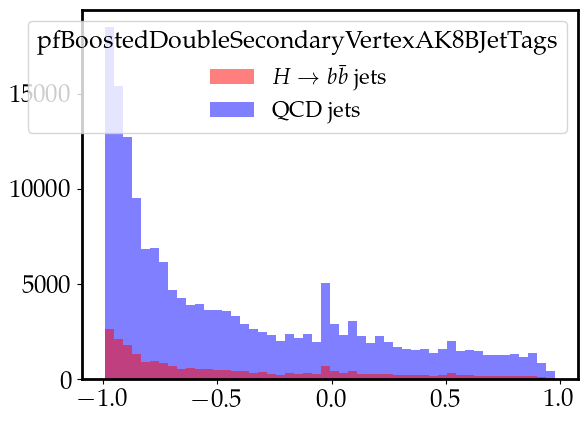

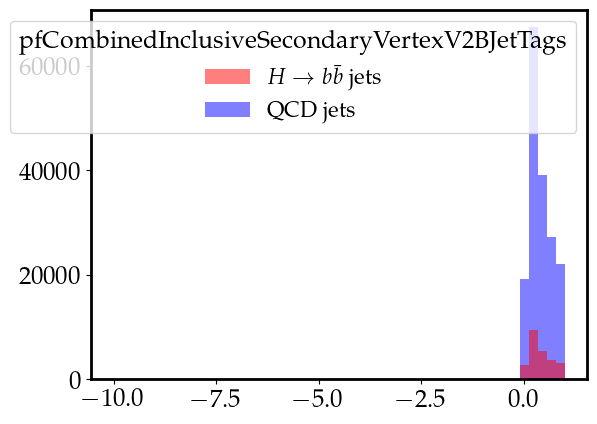

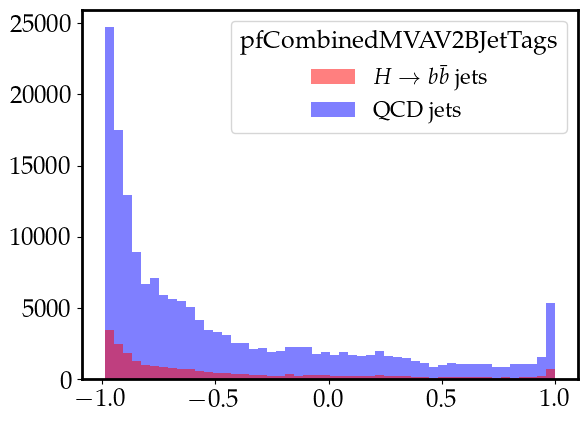

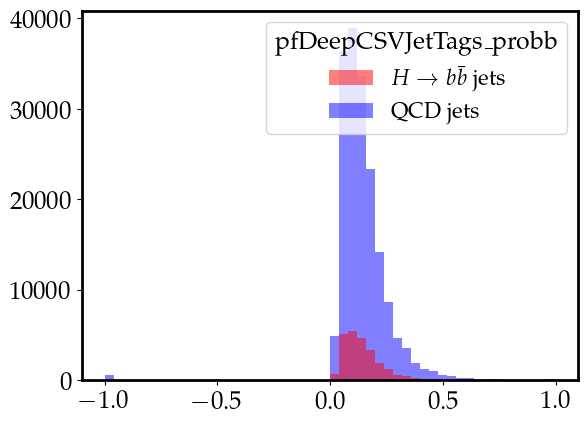

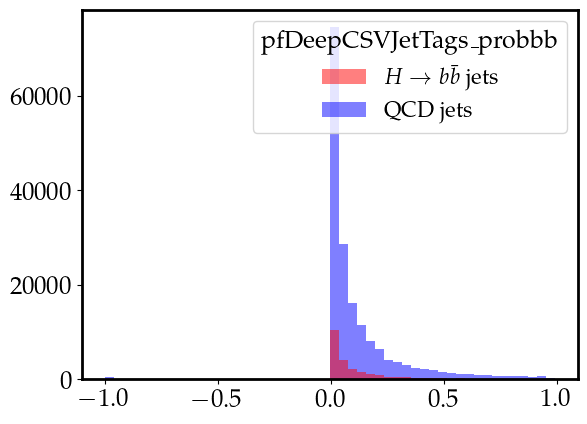

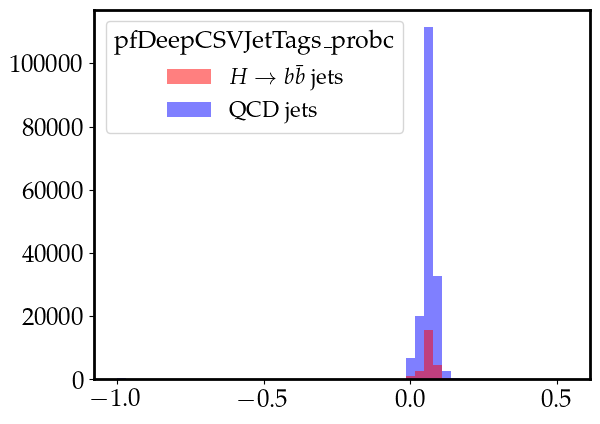

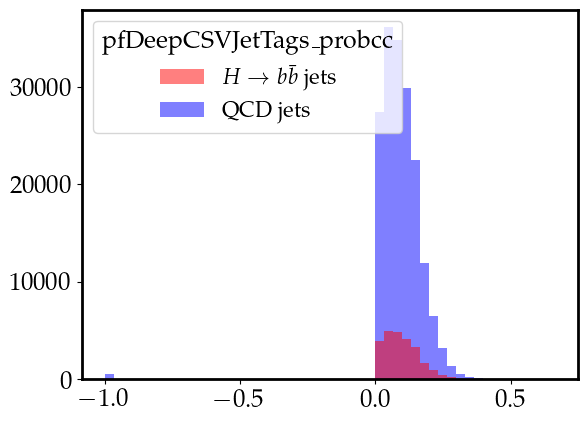

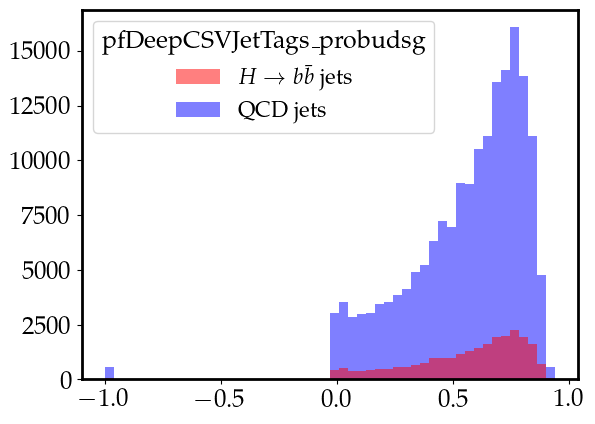

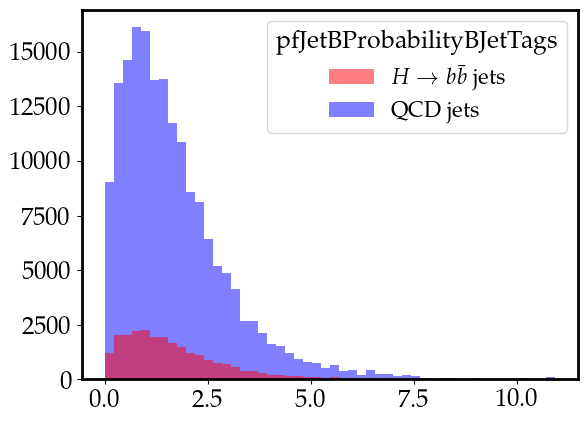

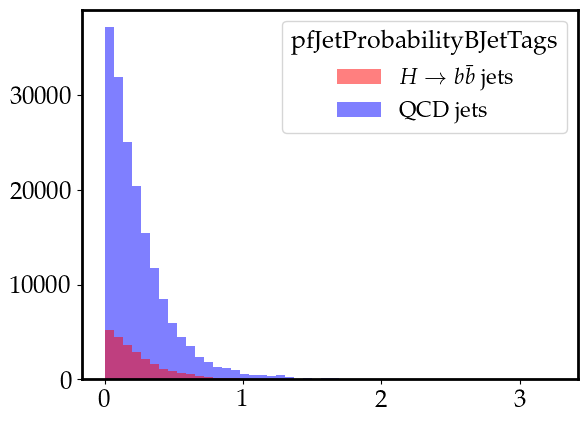

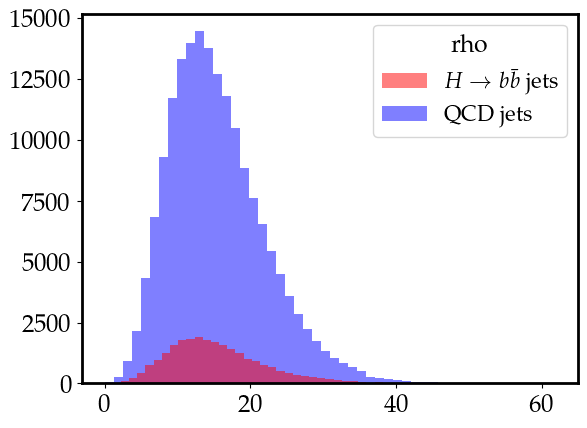

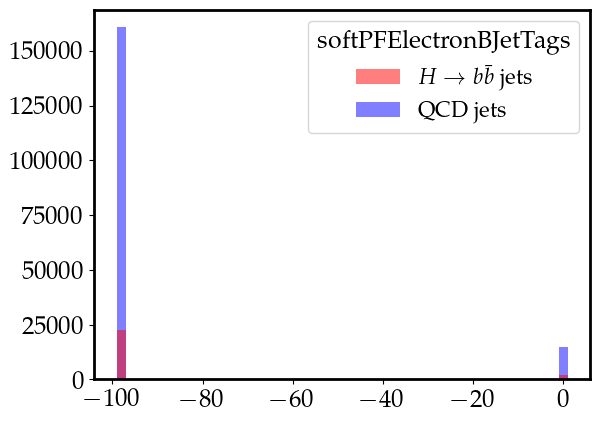

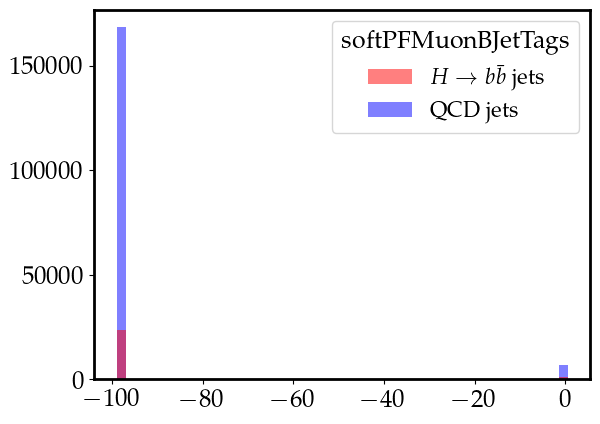

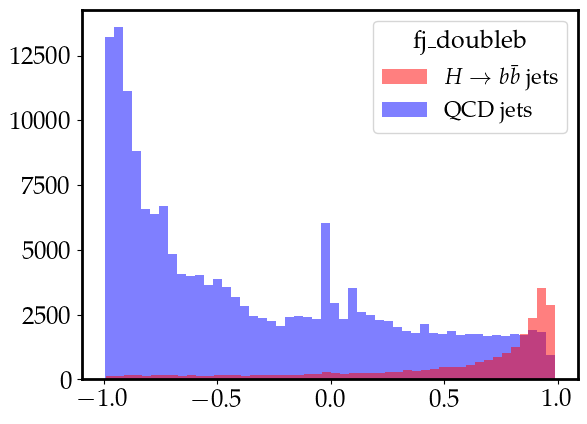

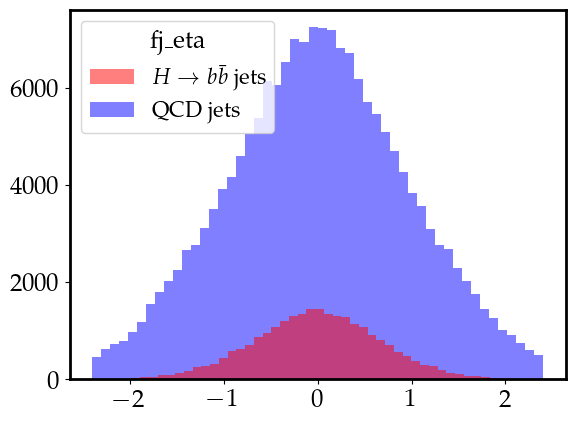

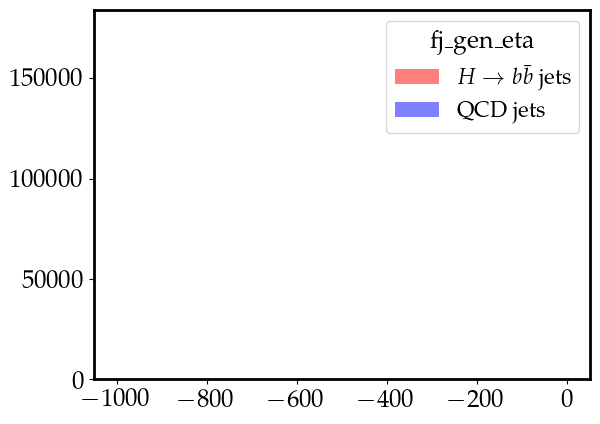

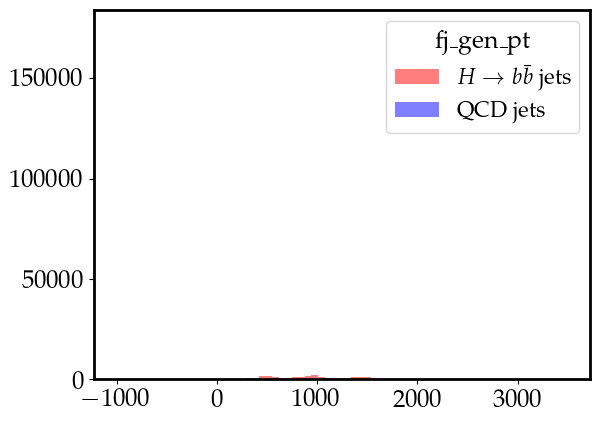

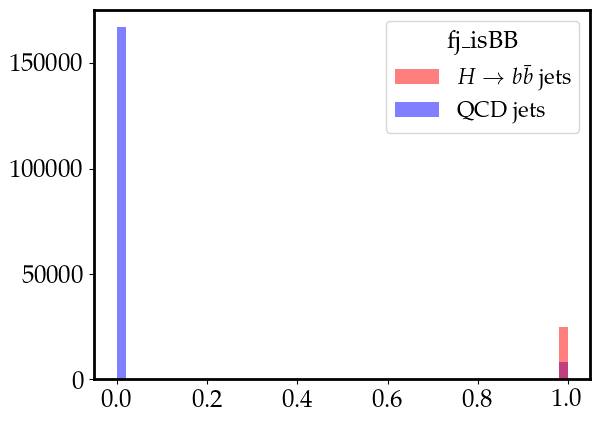

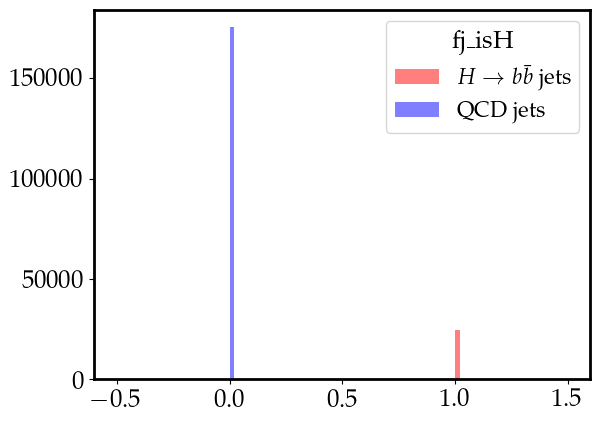

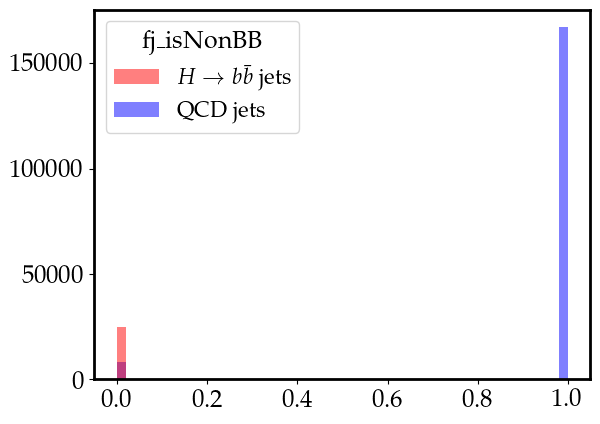

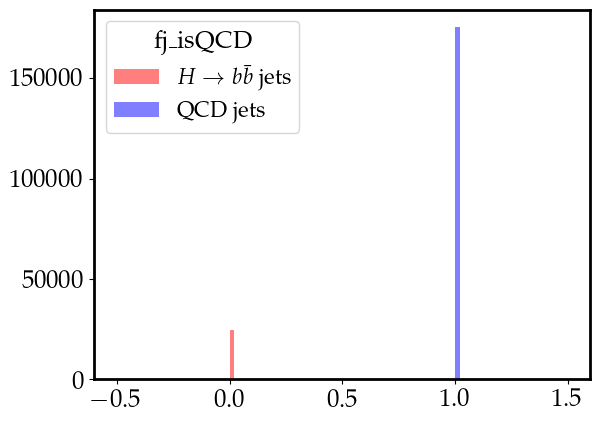

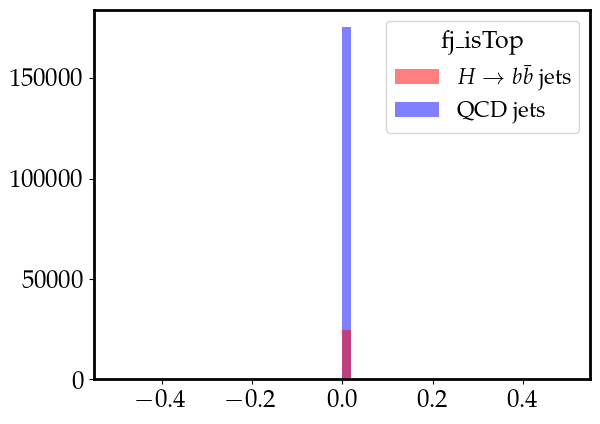

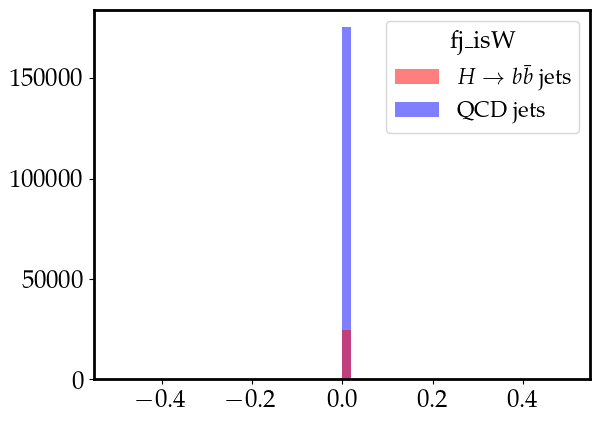

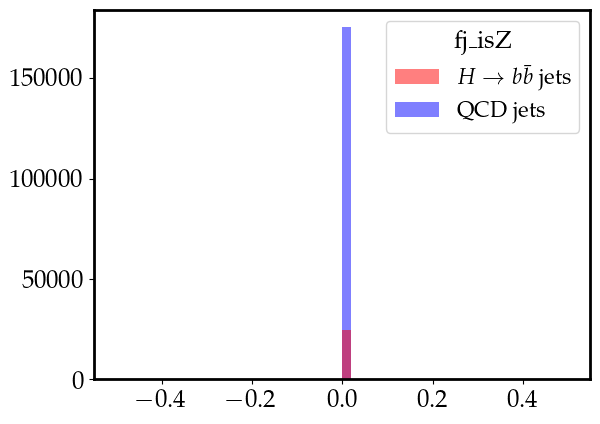

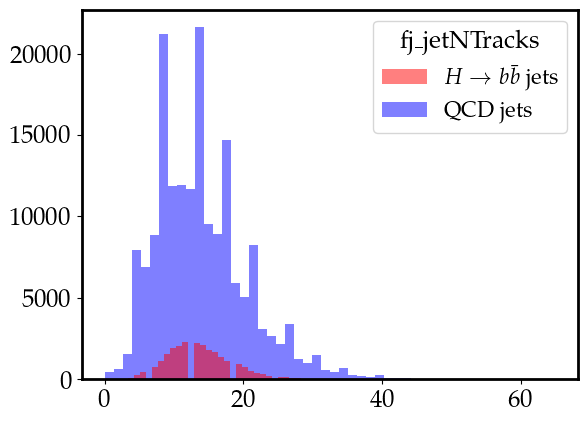

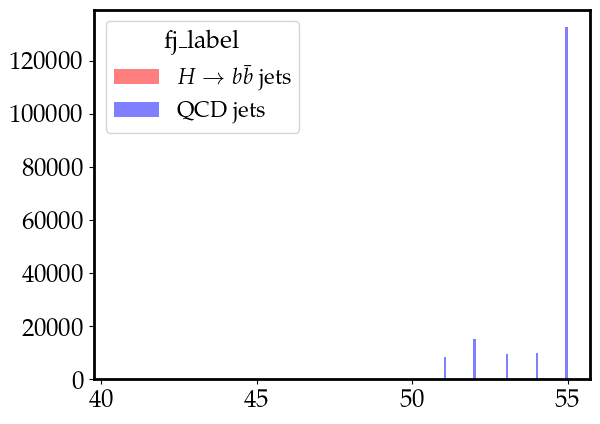

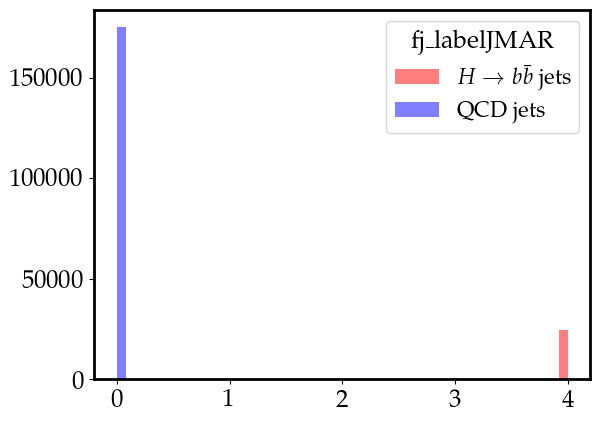

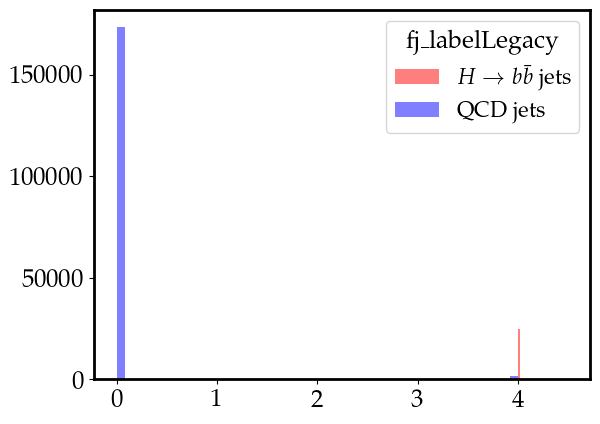

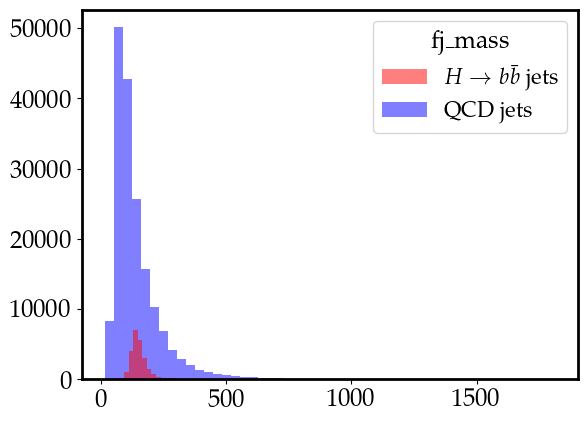

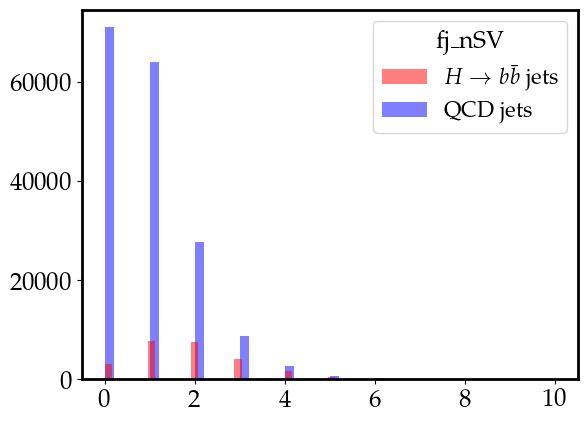

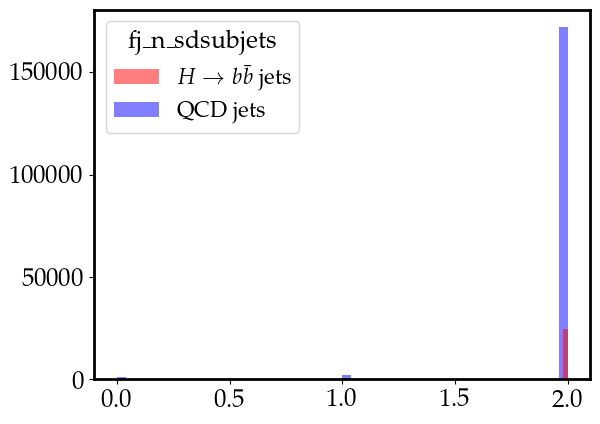

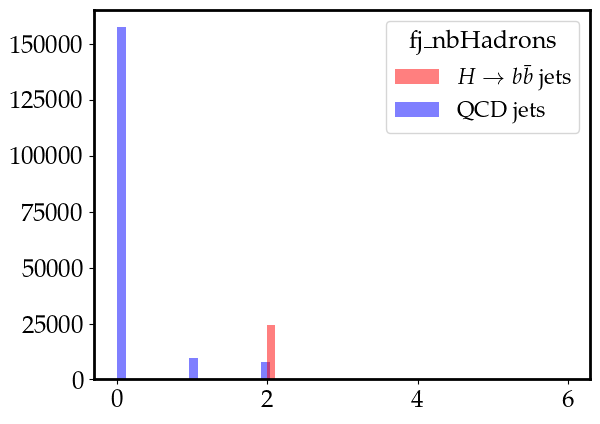

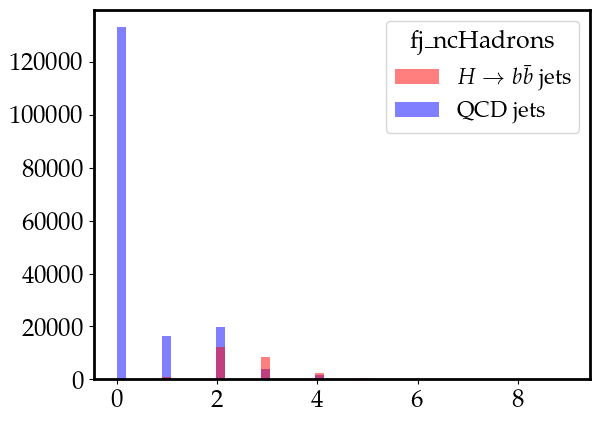

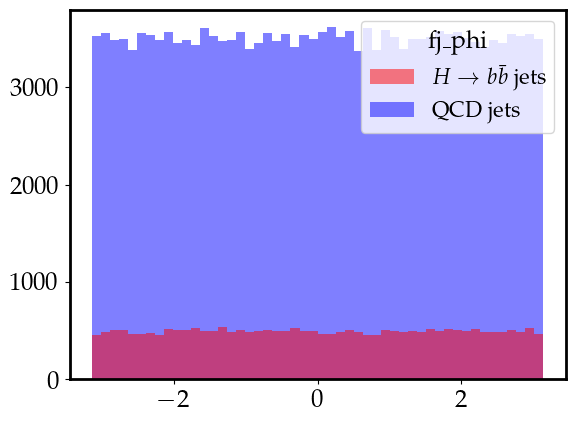

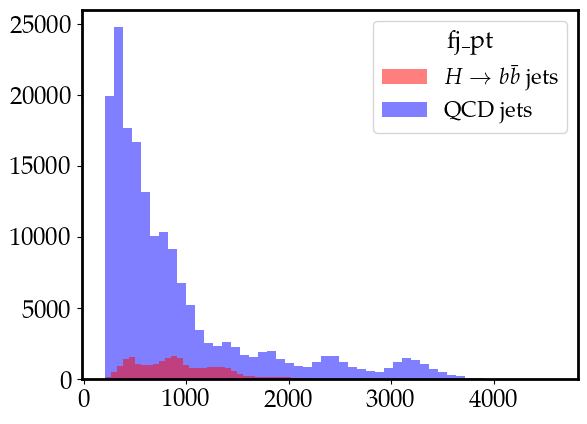

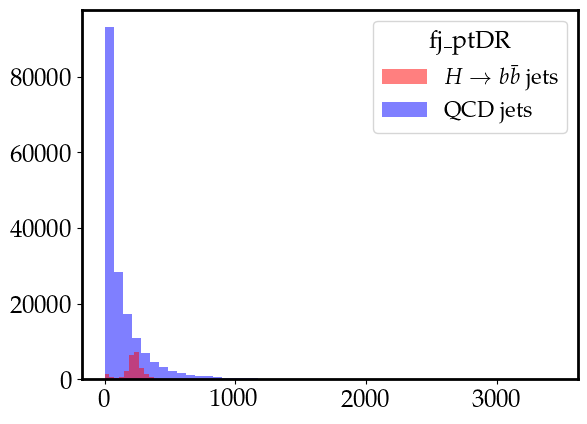

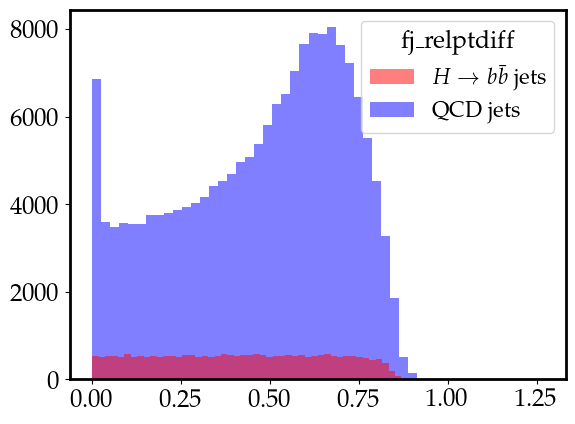

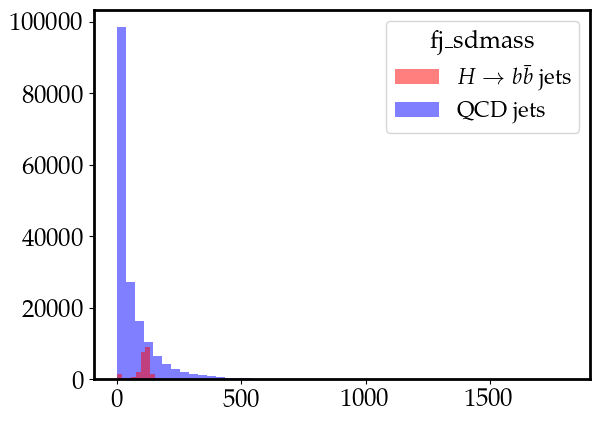

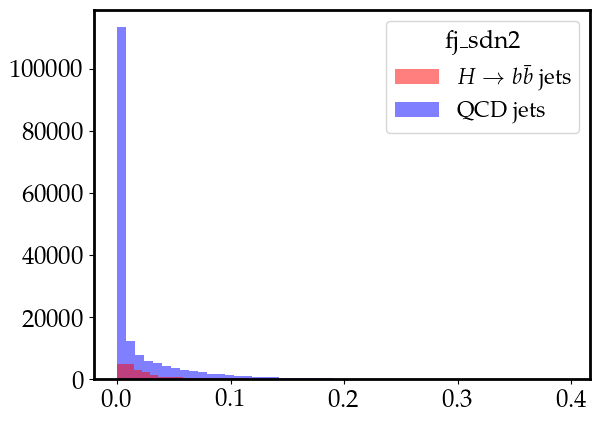

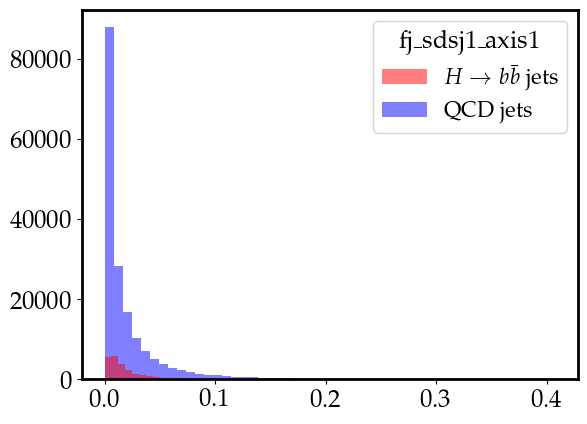

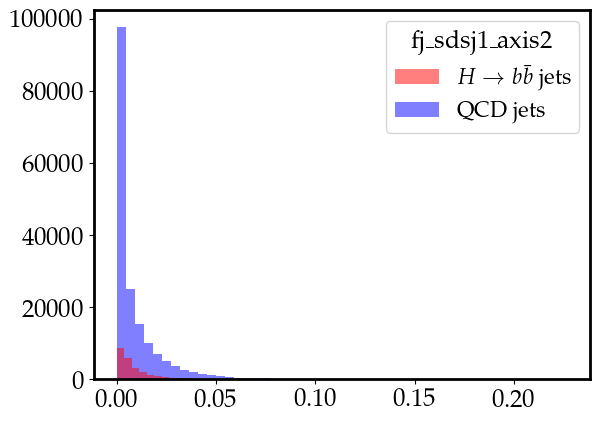

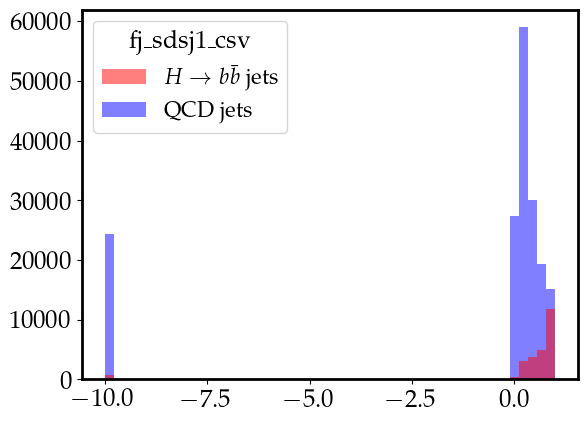

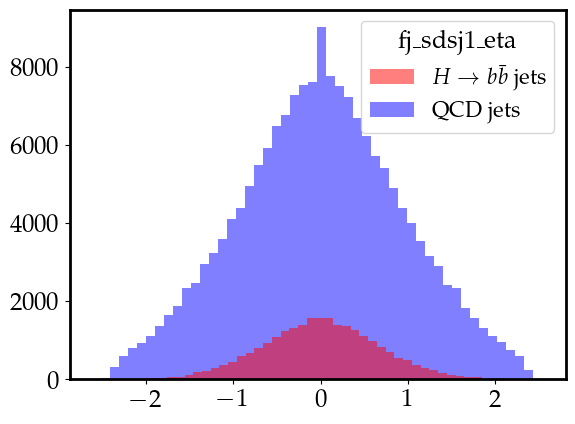

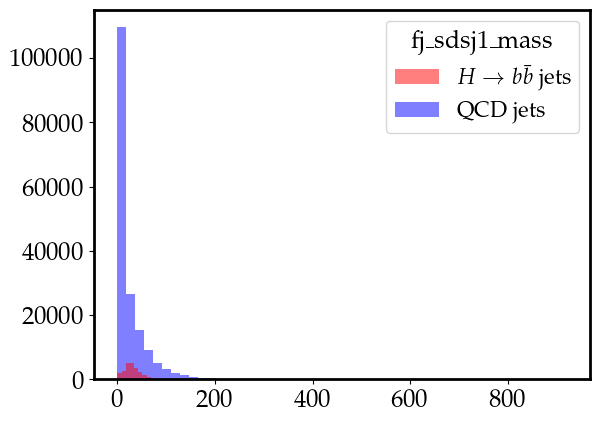

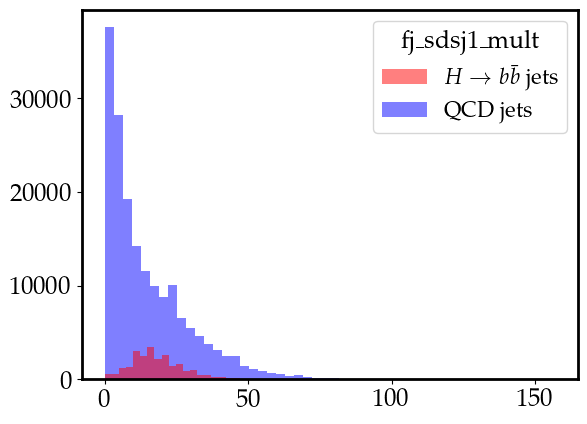

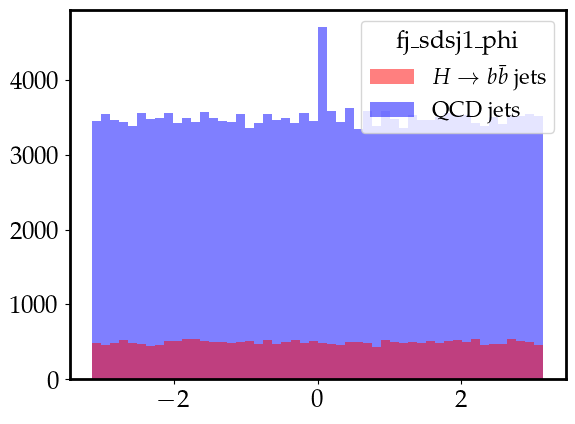

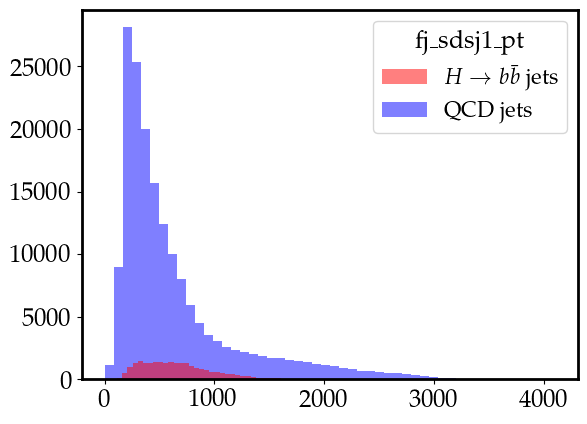

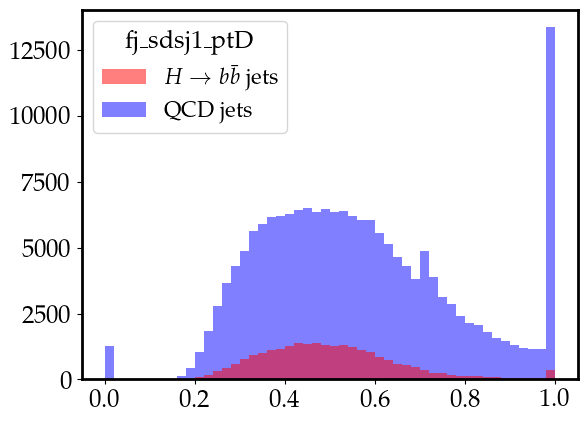

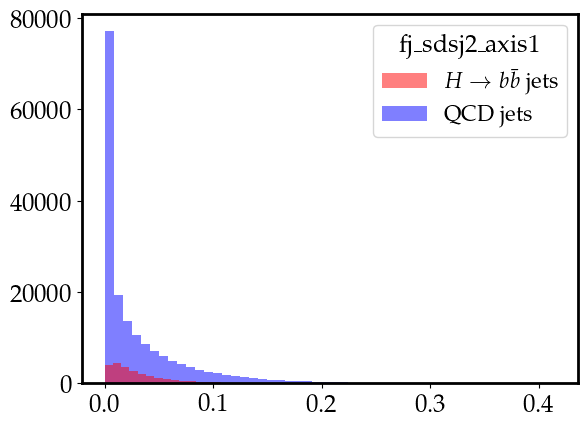

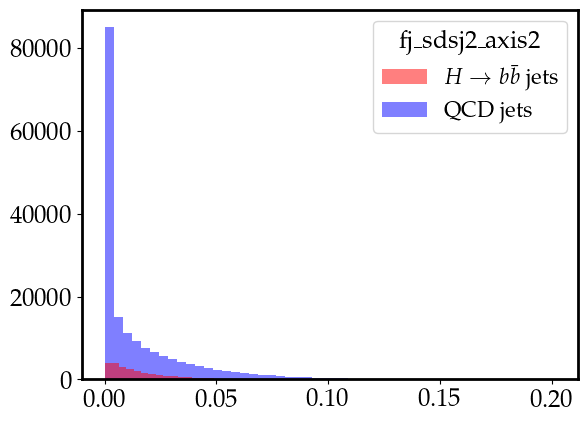

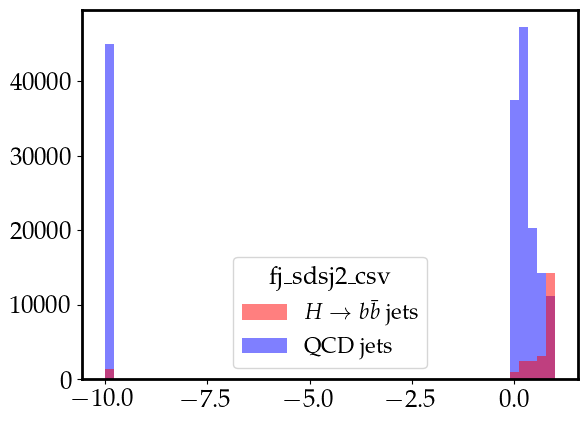

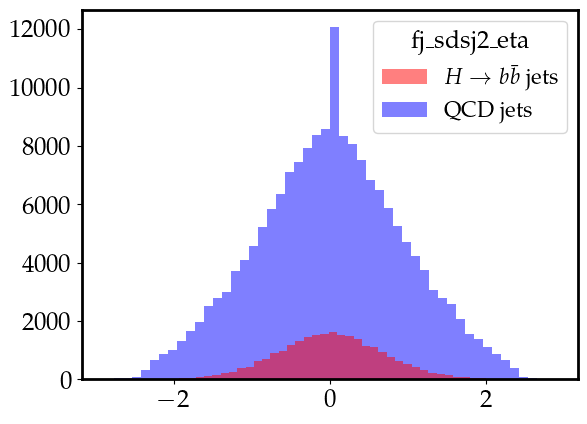

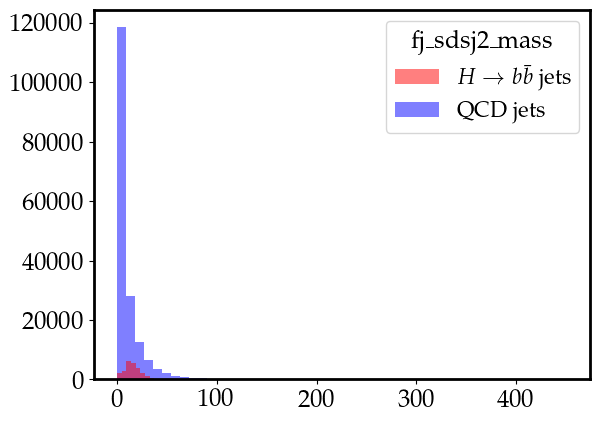

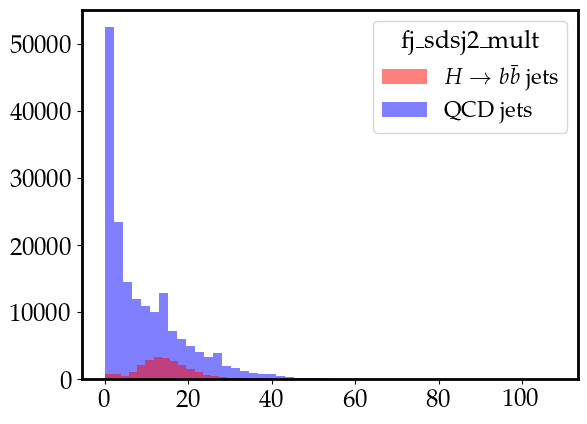

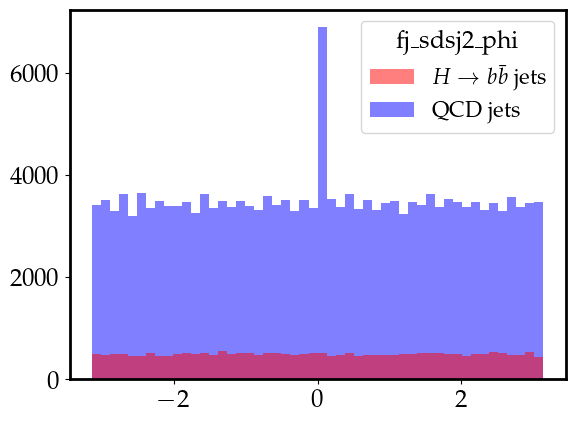

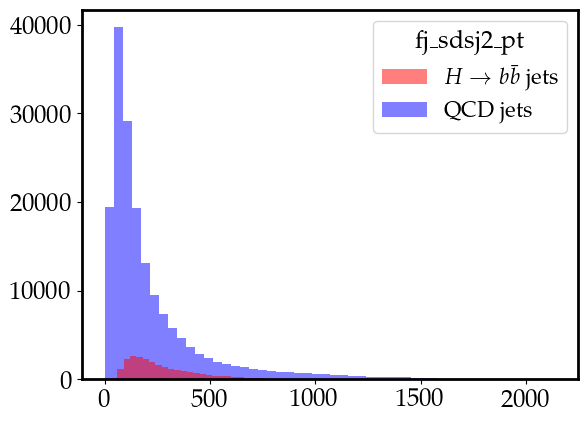

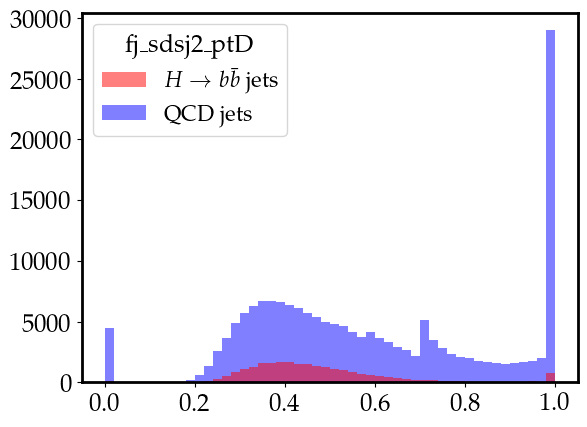

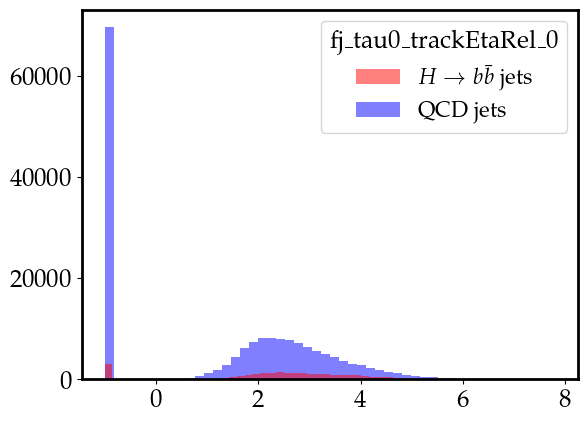

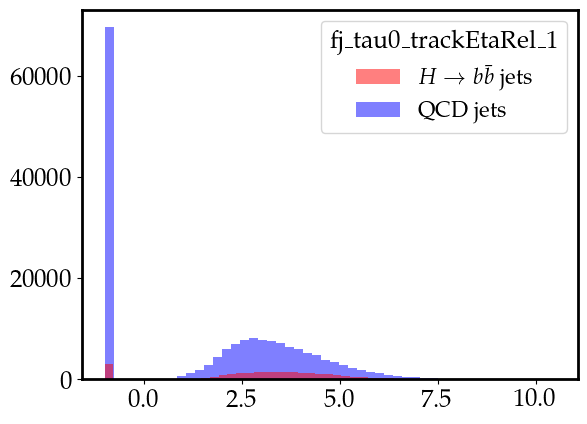

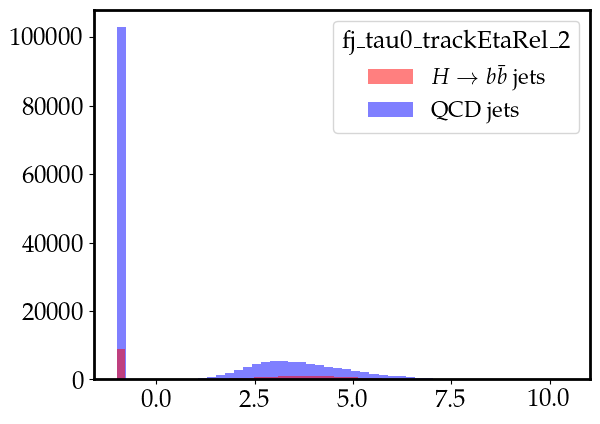

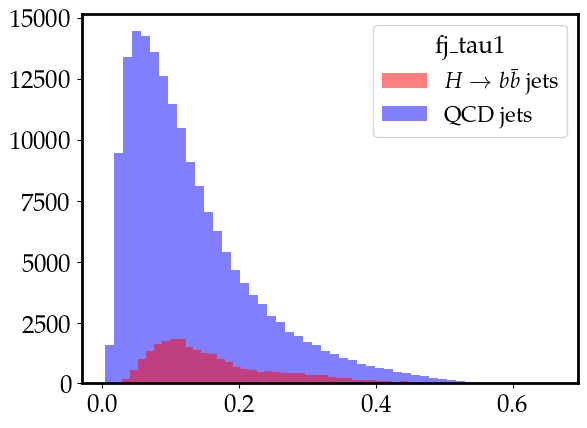

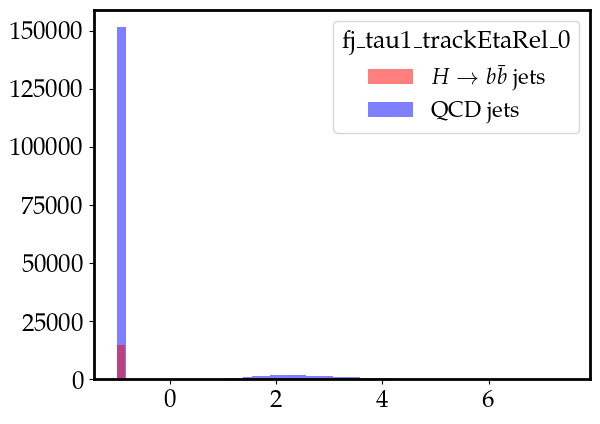

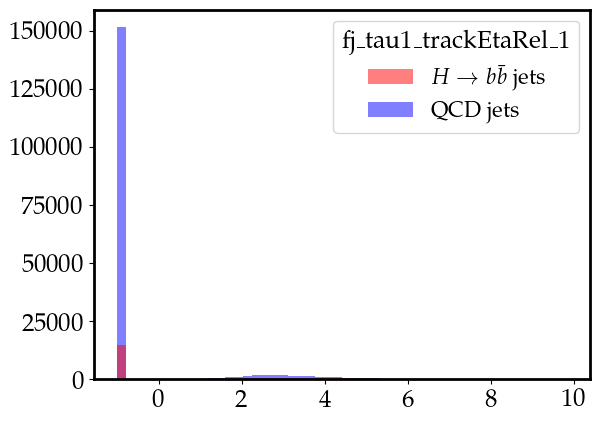

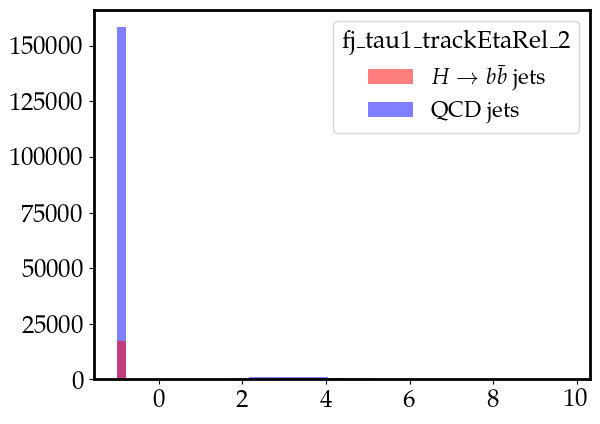

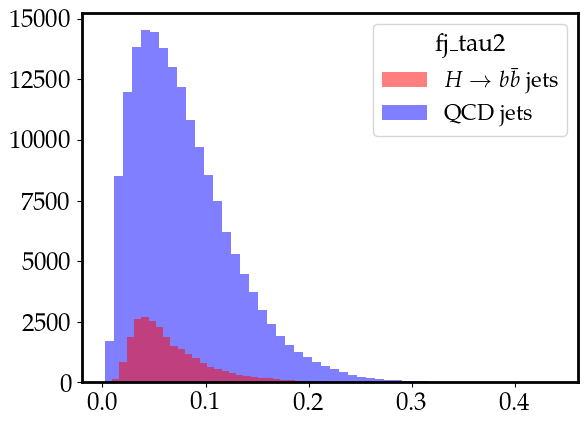

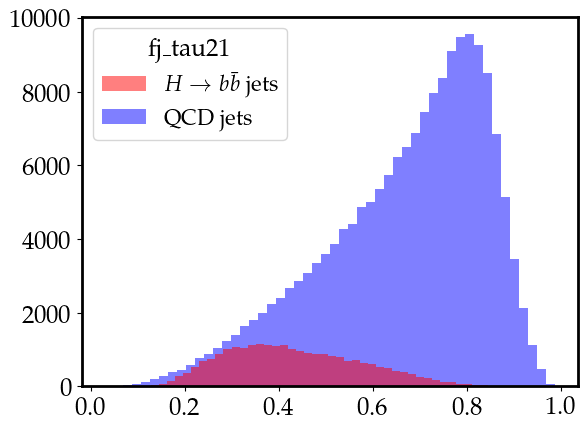

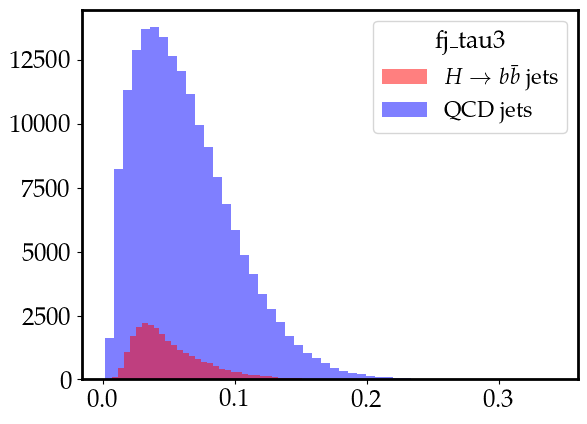

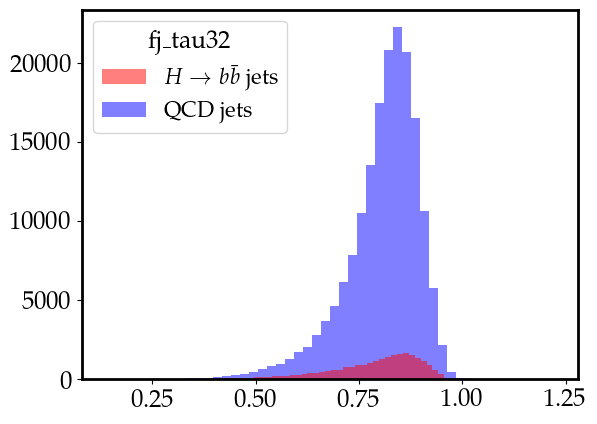

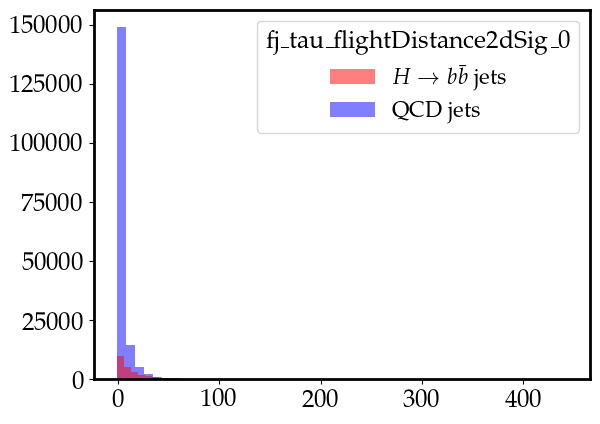

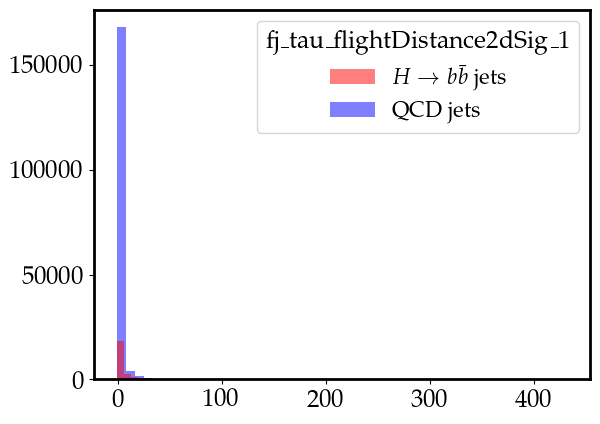

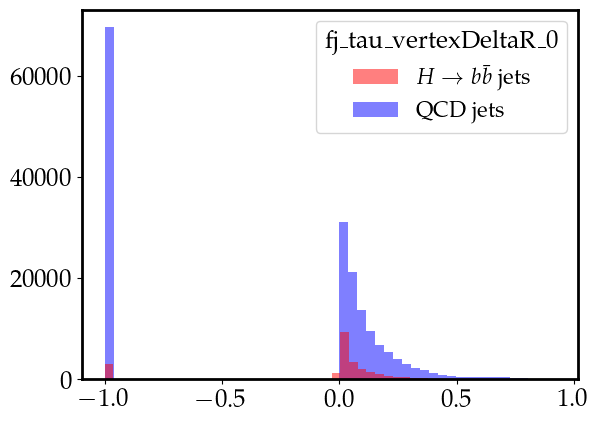

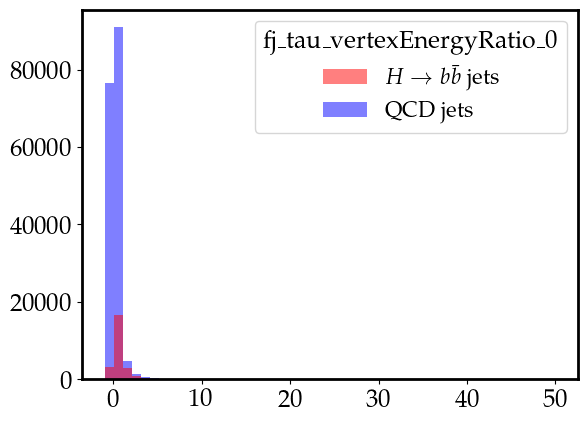

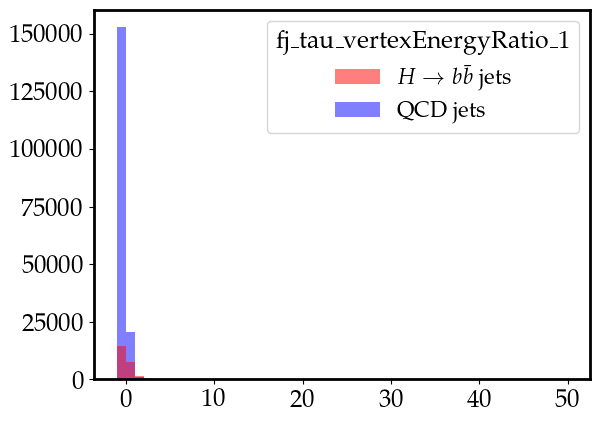

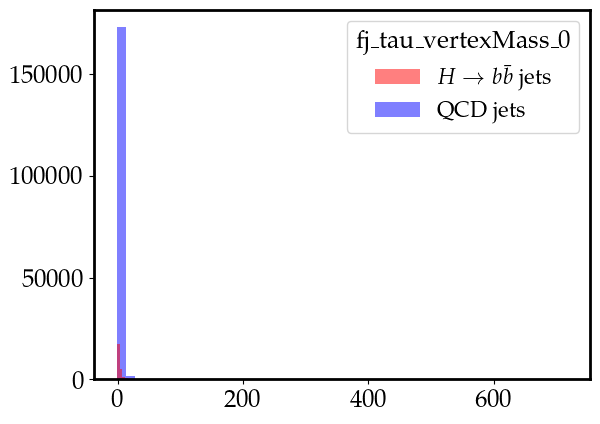

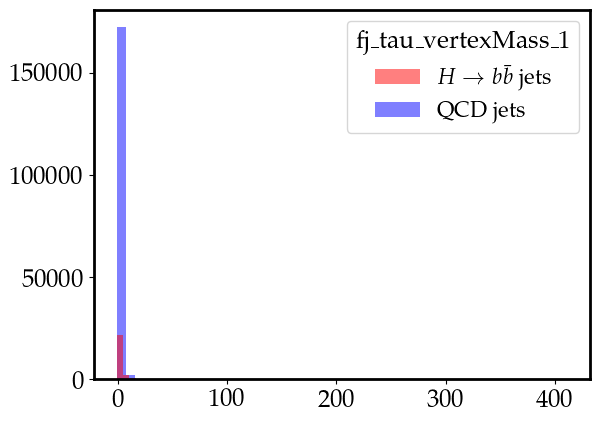

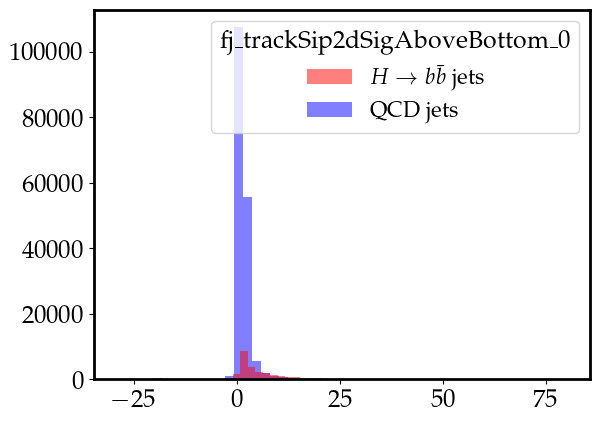

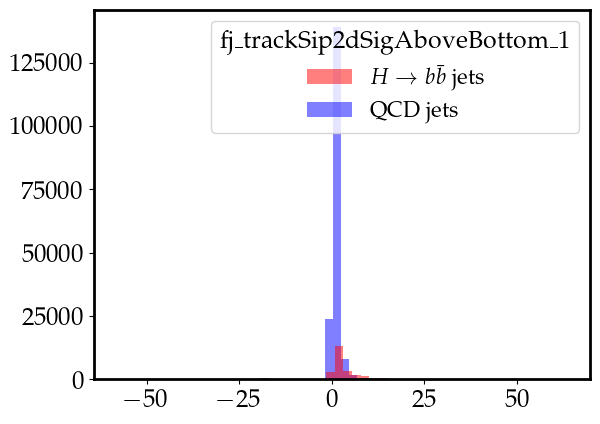

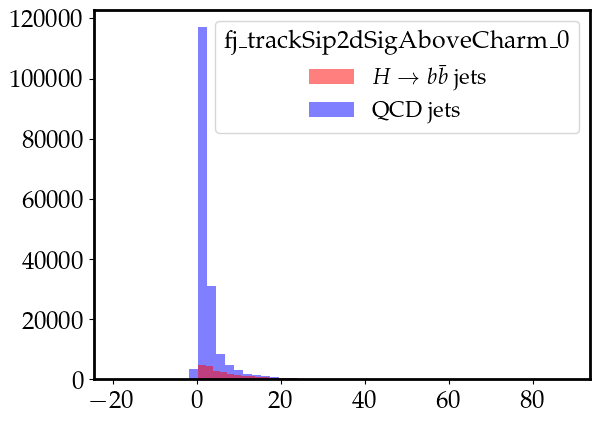

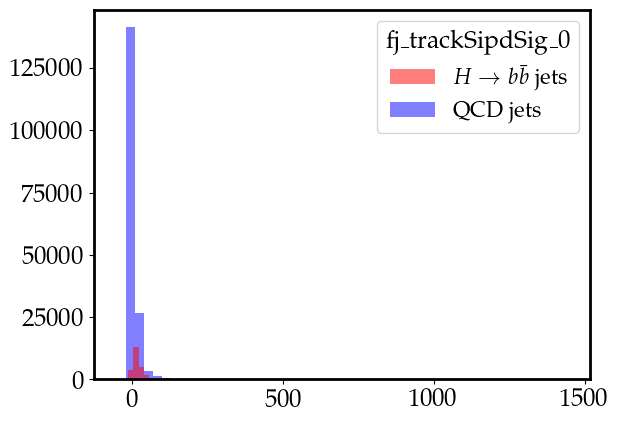

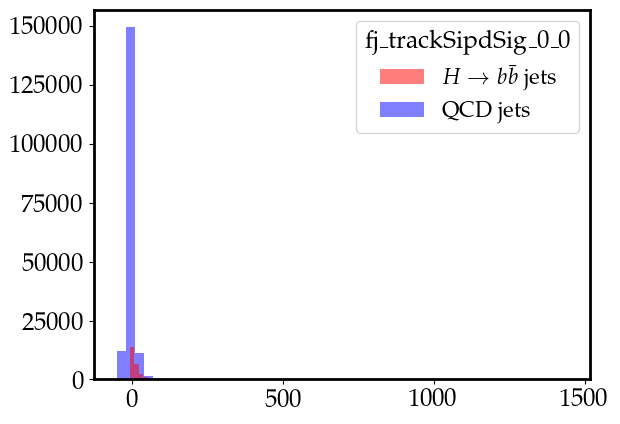

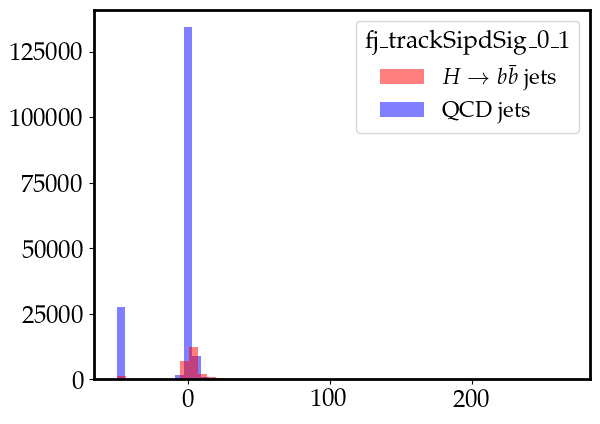

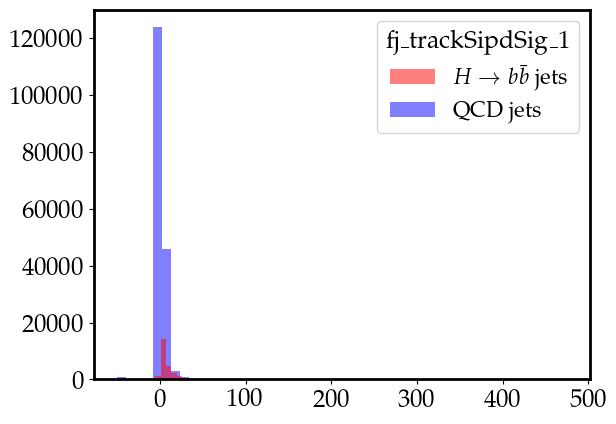

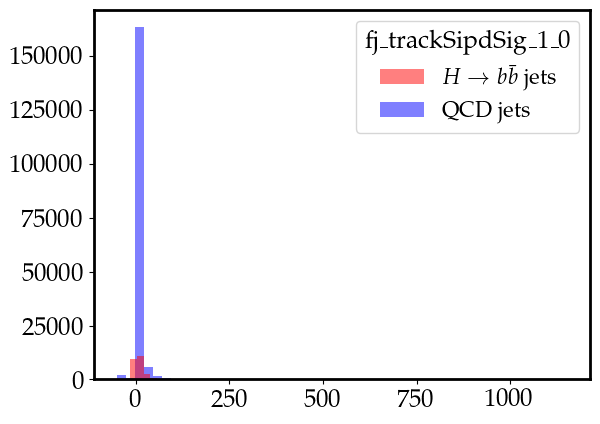

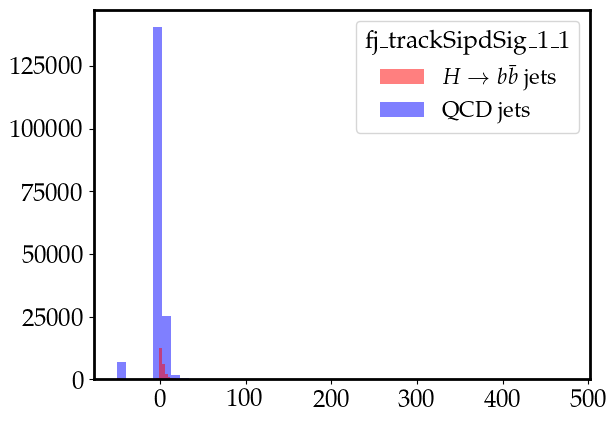

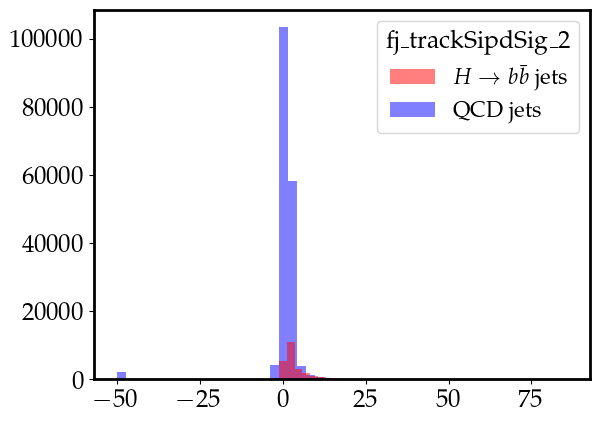

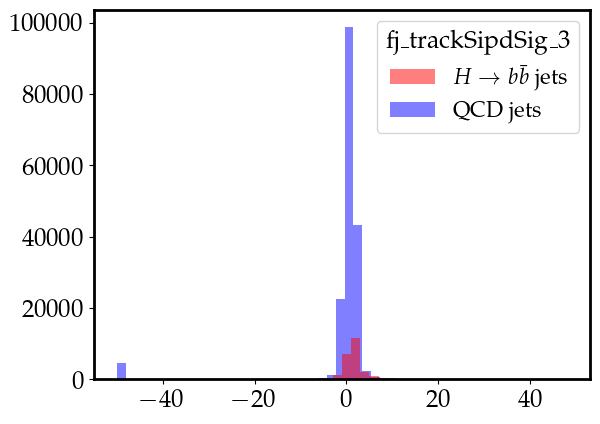

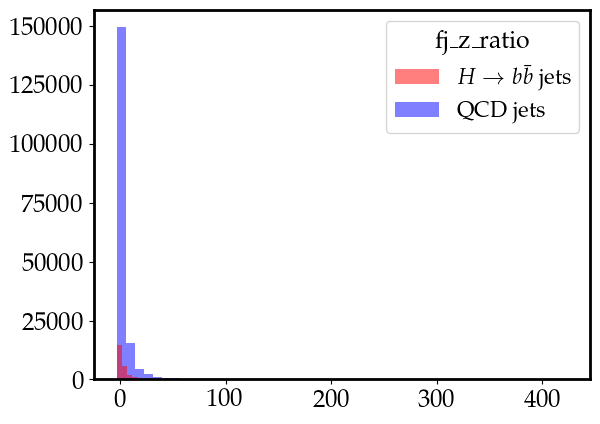

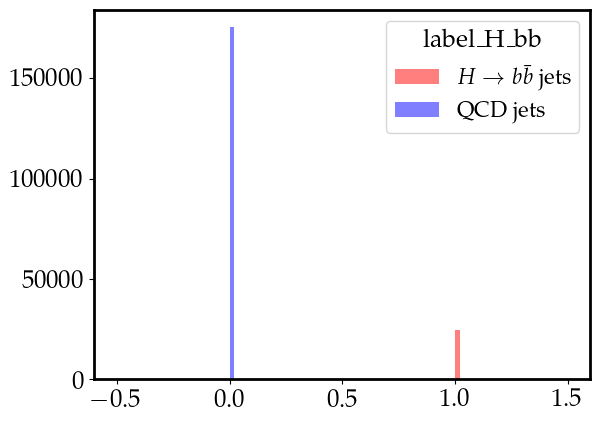

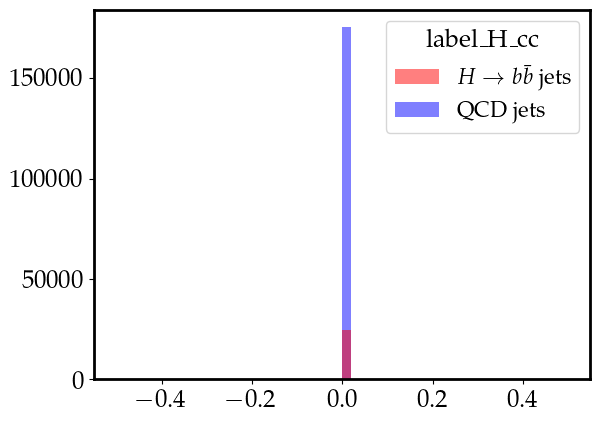

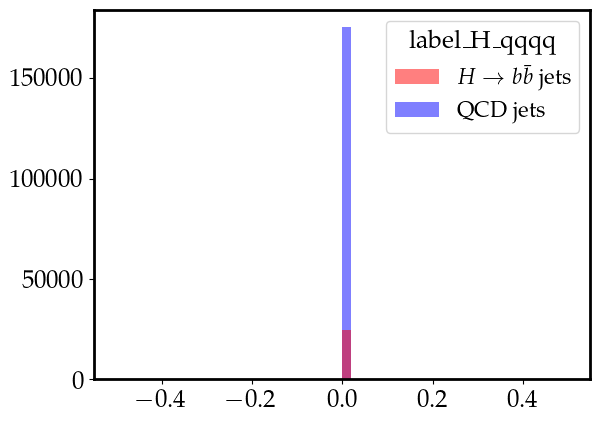

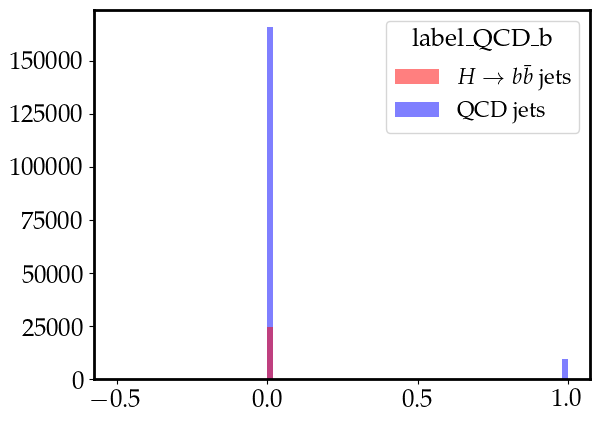

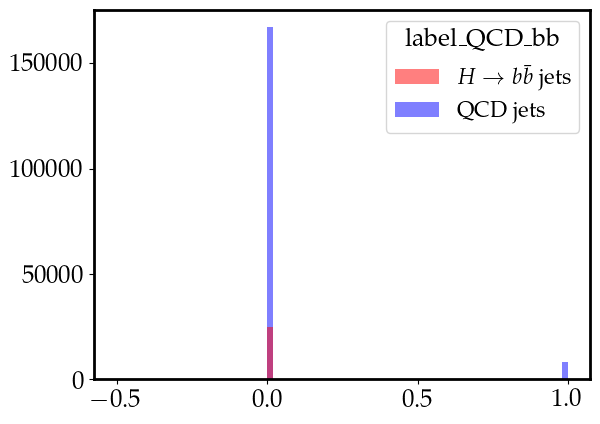

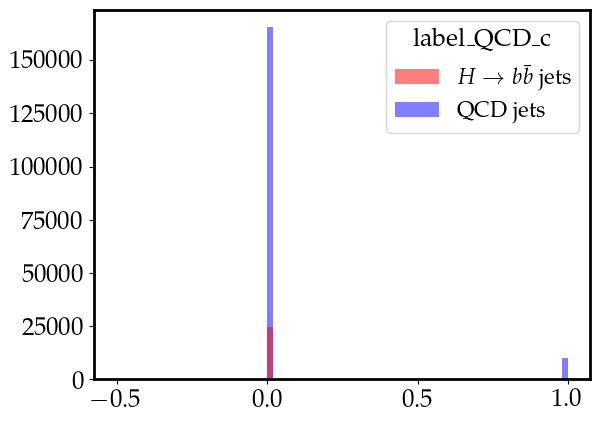

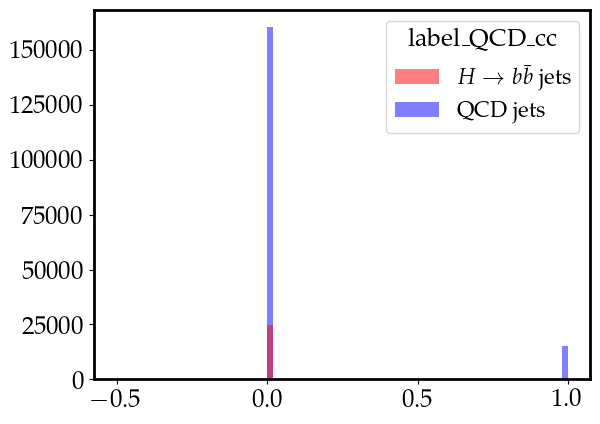

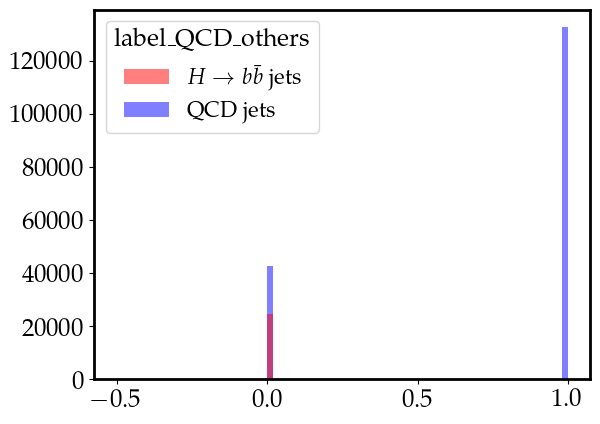

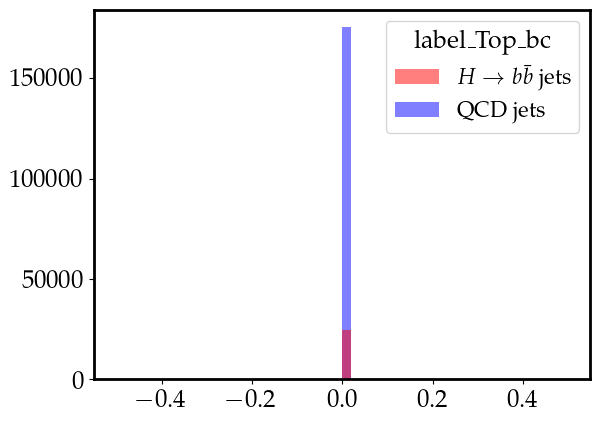

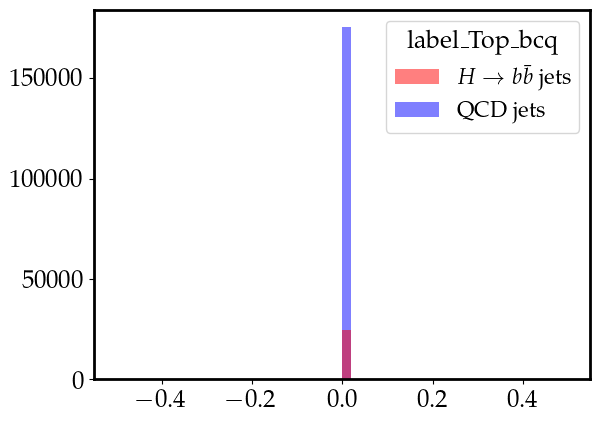

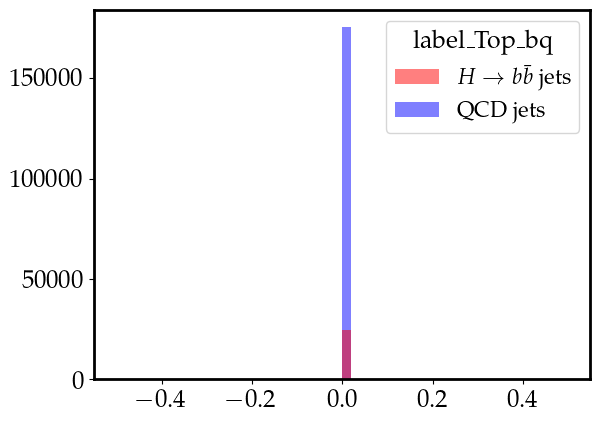

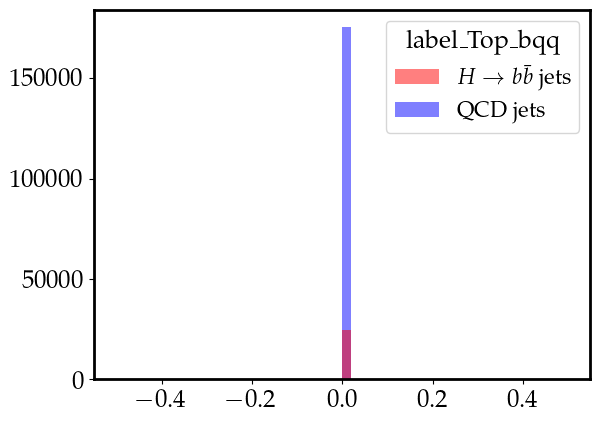

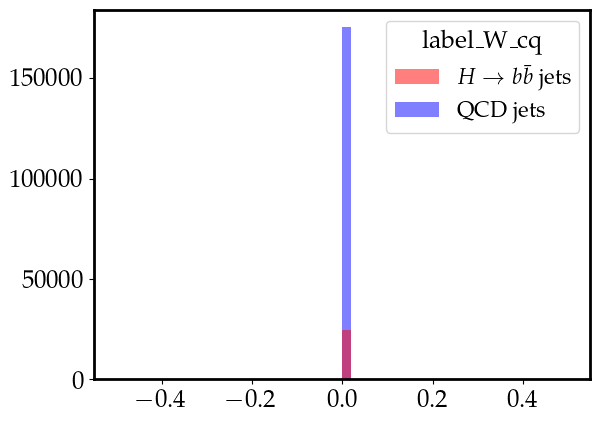

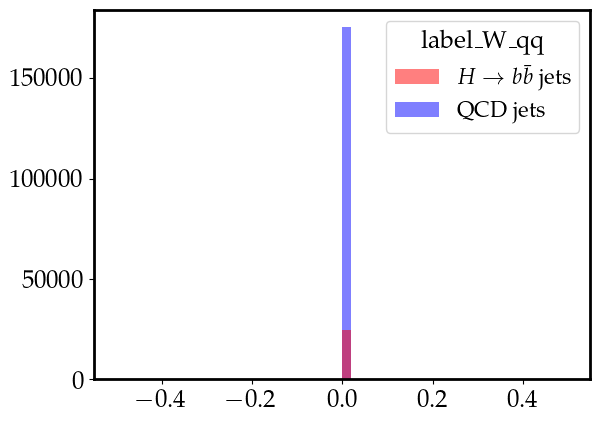

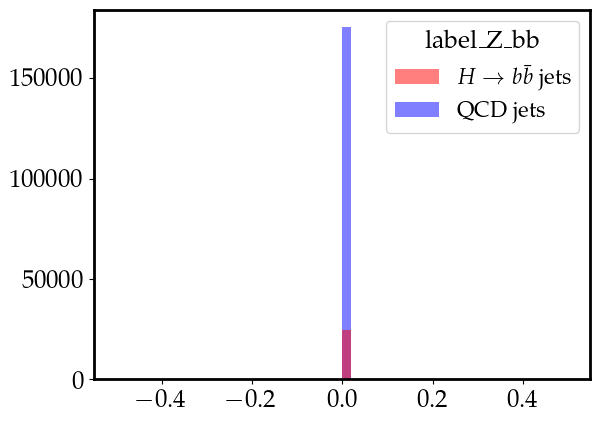

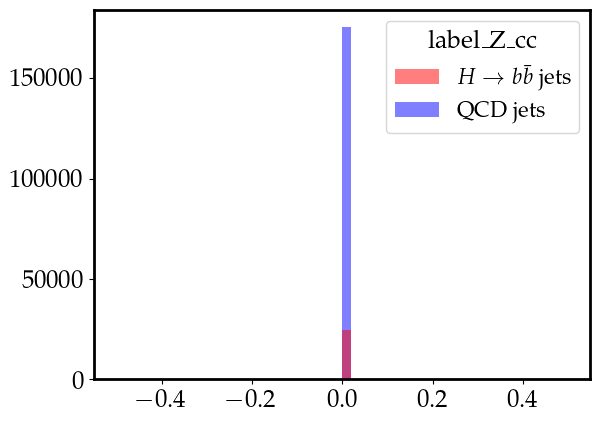

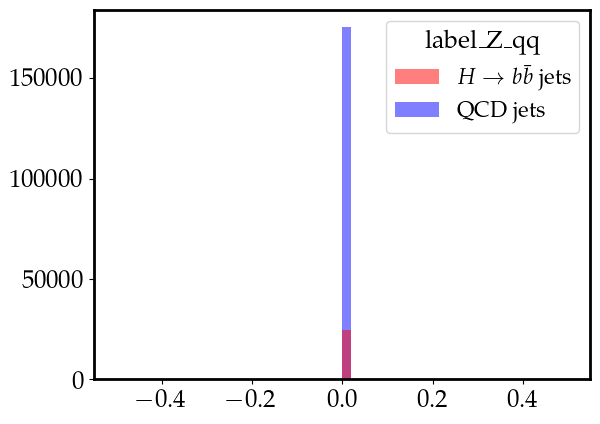

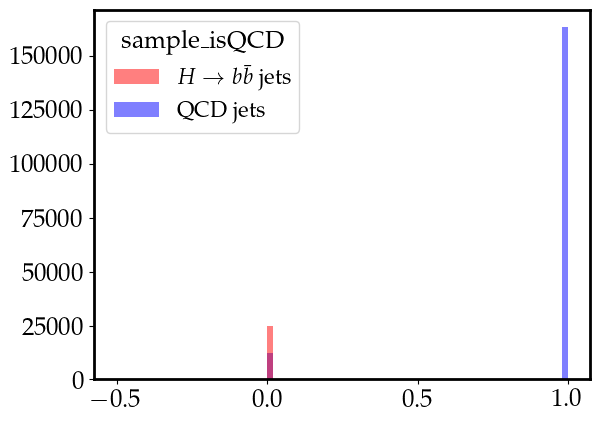

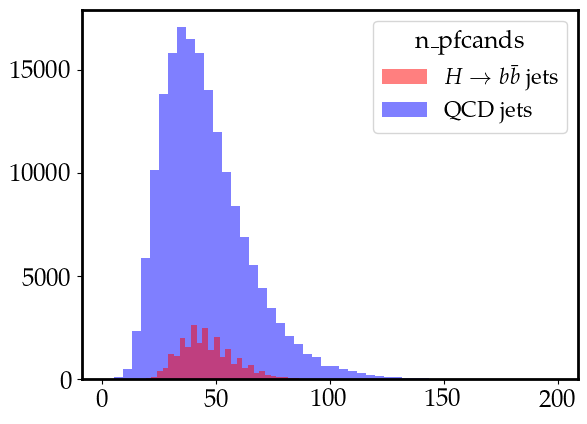

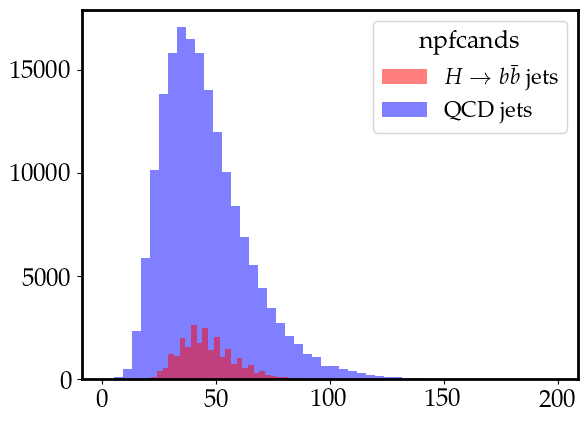

jagged array pfcand_VTX_ass
jagged array pfcand_charge
jagged array pfcand_deltaR
jagged array pfcand_drminsv
jagged array pfcand_drsubjet1
jagged array pfcand_drsubjet2
jagged array pfcand_dxy
jagged array pfcand_dxysig
jagged array pfcand_dz
jagged array pfcand_dzsig
jagged array pfcand_erel
jagged array pfcand_etarel
jagged array pfcand_fromPV
jagged array pfcand_hcalFrac
jagged array pfcand_isChargedHad
jagged array pfcand_isEl
jagged array pfcand_isGamma
jagged array pfcand_isMu
jagged array pfcand_isNeutralHad
jagged array pfcand_lostInnerHits
jagged array pfcand_mass
jagged array pfcand_phirel
jagged array pfcand_ptrel
jagged array pfcand_puppiw


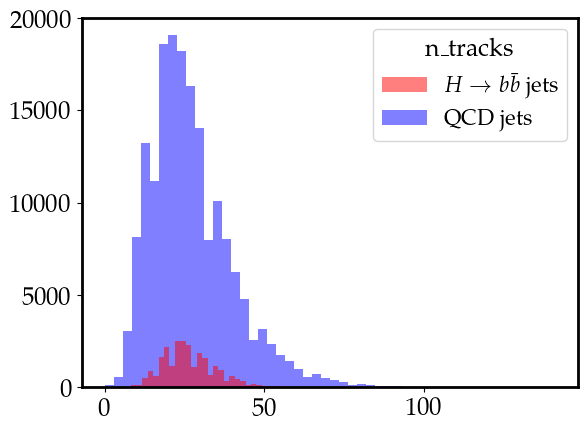

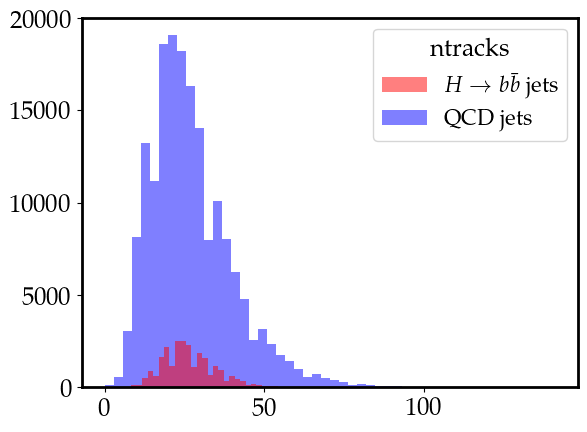

jagged array trackBTag_DeltaR
jagged array trackBTag_Eta
jagged array trackBTag_EtaRel
jagged array trackBTag_JetDistVal
jagged array trackBTag_Momentum
jagged array trackBTag_PPar
jagged array trackBTag_PParRatio
jagged array trackBTag_PtRatio
jagged array trackBTag_PtRel
jagged array trackBTag_Sip2dSig
jagged array trackBTag_Sip2dVal
jagged array trackBTag_Sip3dSig
jagged array trackBTag_Sip3dVal
jagged array track_VTX_ass
jagged array track_charge
jagged array track_deltaR
jagged array track_detadeta
jagged array track_dlambdadz
jagged array track_dphidphi
jagged array track_dphidxy
jagged array track_dptdpt
jagged array track_drminsv
jagged array track_drsubjet1
jagged array track_drsubjet2
jagged array track_dxy
jagged array track_dxydxy
jagged array track_dxydz
jagged array track_dxysig
jagged array track_dz
jagged array track_dzdz
jagged array track_dzsig
jagged array track_erel
jagged array track_etarel
jagged array track_fromPV
jagged array track_isChargedHad
jagged array trac

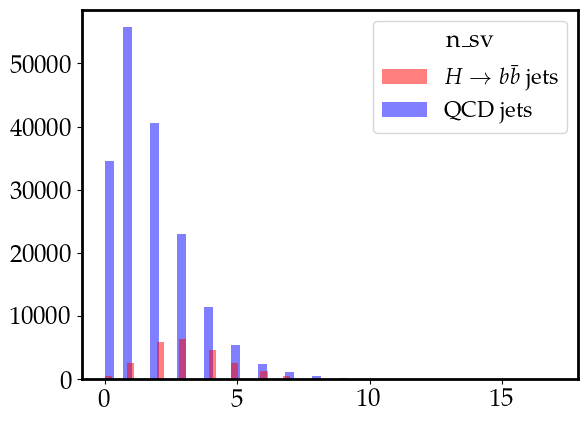

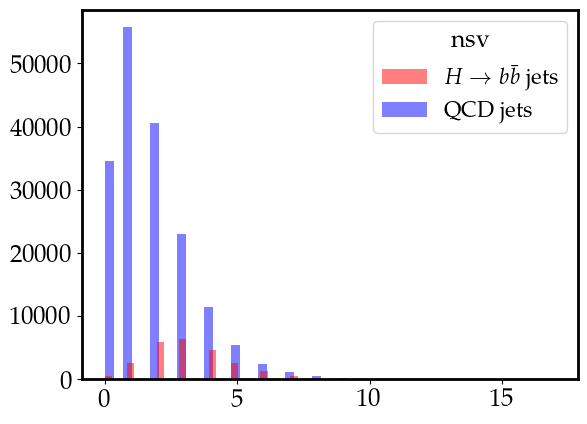

jagged array sv_chi2
jagged array sv_costhetasvpv
jagged array sv_d3d
jagged array sv_d3derr
jagged array sv_d3dsig
jagged array sv_deltaR
jagged array sv_dxy
jagged array sv_dxyerr
jagged array sv_dxysig
jagged array sv_erel
jagged array sv_etarel
jagged array sv_mass
jagged array sv_ndf
jagged array sv_normchi2
jagged array sv_ntracks
jagged array sv_phirel
jagged array sv_pt
jagged array sv_ptrel


In [68]:
for key in tqdm(df.keys()):
    arr = df[key].array()
    if arr.ndim == 1:
        plt.figure()
        plt.hist(arr[df['label_H_bb'].array()==1],alpha=0.5,bins=50,color='r',zorder=2,label=r'$H\rightarrow b\bar{b}$ jets')
        plt.hist(arr[df['label_H_bb'].array()==0],alpha=0.5,bins=50,color='b',label=r'QCD jets')
        plt.legend(title=key)
        plt.show()
    else:
        print("jagged array",key)